# Kepler model

## Settings

In [1]:
import numpy as np
import tensorflow as tf
import sys
sys.path.append("../")
import os
import matplotlib.pyplot as plt

from models import *
from hamiltonians import kepler
from utils import make_train_op
from losses import make_loss
from data import make_data
from utils import visualize_chain_bijector, is_symplectic

DTYPE=tf.float32
NP_DTYPE=np.float32

In [2]:
sess = tf.InteractiveSession()

In [3]:
tf.set_random_seed(0)

In [4]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [5]:
settings = {
    'hamiltonian': lambda x : kepler(x,k=-1),
    'd': 2,                    # space dimension
    'num_particles': 1,        # number of particles
    'minibatch_size': 2**10,    # Mini batch size
    'dataset_size': 2**10, # Set to float("inf") for keeping sampling.
    'num_stacks_bijectors': 4, # Number of bijectors
    'log_dir' : "/tmp/log/im_tests/kepler-2",
    'visualize': True,
    #
    'starter_learning_rate': 1e-3, # for exp decay and none
    'decay_lr': "piecewise",
#     'decay_steps': 15000,  # for exp decay
#     'decay_rate': 0.5,     # for exp decay
    'boundaries': [50000, 100000], # for piecewise decay
    'values': [1e-3, 1e-4, 1e-5],  # for piecewise decay
    'min_learning_rate': 1e-5, 
    #
    'loss': "dKdphi",
    'base_dist': "action_dirac_angle",
    'value_actions': [.01, .2], # has to be same len as phase space dim
    'diff_val': -.5, 
    'lambda_diff': 1.   # coeff |K-val|^2
#     ,
#     'elastic_net_coeff': 0., 
#     'low_K_range': -100, # A large value means all above this are OK
#     'high_K_range': -.01, 
#     'lambda_range': 10000.    # coeff range penalty
    }

## Eqs of motion

Preliminarly, numerical solution of eom. Here $V(r) = k/r$, with $k>0$ repulsive, $k<0$ attractive (ellipses)

In [6]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(settings['hamiltonian'],
                             initial_t=0., 
                             final_t=10., 
                             num_steps=1000)
eccentricity = .6
# q0, p0, q1, p1, ...
x0 = tf.reshape([1-eccentricity, 0., 0, np.sqrt((1+eccentricity) / (1-eccentricity)), 0, 0], [1,3,1,2])
q0,p0 = extract_q_p(x0)
print(q0.eval())
print(p0.eval())

[[[[0.4]]

  [[0. ]]

  [[0. ]]]]
[[[[0.]]

  [[2.]]

  [[0.]]]]


In [7]:
traj = sess.run( integrator(x0, return_full_state=True) )
# traj has shape (time,batch,d,n,2) Here batch trivial, squeeze it out, so that time becomes batch
traj = np.squeeze(traj, 1)
qtraj, ptraj = extract_q_p( traj )

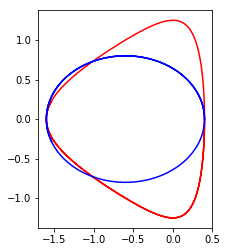

In [8]:
# orbits
dd = 0; nn = 0;
plt.plot(qtraj[:,dd,nn,0], ptraj[:,dd,nn,0],'r')

plt.plot(qtraj[:,0,nn,0], qtraj[:,1,nn,0],'b')

plt.gca().set_aspect('equal', adjustable='box')

In [9]:
from utils import join_q_p

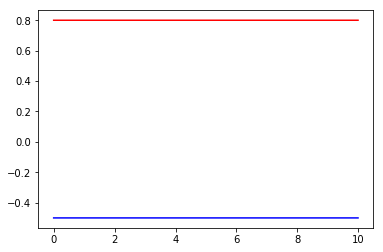

In [10]:
# conserved quantities: angular momentum and energy
J3 = np.multiply(qtraj[:,0,0,0], ptraj[:,1,0,0]) - np.multiply(qtraj[:,1,0,0], ptraj[:,0,0,0])
E = sess.run( settings['hamiltonian']( join_q_p(qtraj,ptraj) ) )
ts = np.arange(0.,10.,.01)
plt.plot(ts, J3,'r')
plt.plot(ts, E,'b')

## Define the model and loss

Define the model as sequence of a symplectic transformation T 

In [6]:
# To account for periodicity start with oscillator flow
stack = [OscillatorFlow()] 
for i in range(settings['num_stacks_bijectors']):
    stack.extend([ZeroCenter(),
                  LinearSymplecticTwoByTwo(),
                  SymplecticAdditiveCoupling(shift_model=MLP(activation=tf.nn.tanh))])
T = Chain(stack)

In [7]:
step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)

z = make_data(settings, sess)

loss = make_loss(settings, T, z)

train_op = make_train_op(settings, loss, step)

In DiracDistribution constructor: actions =  [0.01 0.2 ]


## Train

In [28]:
# Set the ZeroCenter bijectors to training mode:
T.set_is_training(True)

In [29]:
tf.contrib.training.train(train_op, logdir=settings['log_dir'], 
                          save_checkpoint_secs=60)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/log/im_tests/kepler-2/model.ckpt-123511
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 123511 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 42.3535
INFO:tensorflow:global_step/sec: 88.6366
INFO:tensorflow:global_step/sec: 88.3505
INFO:tensorflow:global_step/sec: 87.2253
INFO:tensorflow:global_step/sec: 88.2678
INFO:tensorflow:global_step/sec: 88.0931
INFO:tensorflow:global_step/sec: 88.2742
INFO:tensorflow:global_step/sec: 89.5828
INFO:tensorflow:global_step/sec: 90.121
INFO:tensorflow:global_step/sec: 88.5763
INFO:tensorflow:global_step/sec: 88.0088
INFO:tensorflow:global_step/sec: 86.7795
INFO:tensorflow:global_step/sec: 88.5198
INFO:tensorflow:global_step/sec: 88.0313
INFO:tensorflow:global_step/sec: 88.9591
INFO:tensorflow:global_step/sec: 87.3863
INFO

INFO:tensorflow:global_step/sec: 87.5736
INFO:tensorflow:global_step/sec: 88.2339
INFO:tensorflow:global_step/sec: 86.4898
INFO:tensorflow:global_step/sec: 87.7617
INFO:tensorflow:global_step/sec: 87.9651
INFO:tensorflow:global_step/sec: 87.5222
INFO:tensorflow:global_step/sec: 86.1977
INFO:tensorflow:global_step/sec: 83.1602
INFO:tensorflow:global_step/sec: 87.0517
INFO:tensorflow:global_step/sec: 88.2475
INFO:tensorflow:global_step/sec: 87.6941
INFO:tensorflow:global_step/sec: 87.5085
INFO:tensorflow:global_step/sec: 85.75
INFO:tensorflow:global_step/sec: 86.6781
INFO:tensorflow:global_step/sec: 83.7603
INFO:tensorflow:global_step/sec: 86.5978
INFO:tensorflow:global_step/sec: 88.6917
INFO:tensorflow:global_step/sec: 86.698
INFO:tensorflow:Saving checkpoints for 143959 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 44.0978
INFO:tensorflow:global_step/sec: 87.7677
INFO:tensorflow:global_step/sec: 87.8837
INFO:tensorflow:global_step/sec: 87.1877
INFO:tensor

INFO:tensorflow:global_step/sec: 86.9566
INFO:tensorflow:global_step/sec: 86.9291
INFO:tensorflow:global_step/sec: 88.0052
INFO:tensorflow:global_step/sec: 85.9871
INFO:tensorflow:global_step/sec: 88.1267
INFO:tensorflow:global_step/sec: 87.7098
INFO:tensorflow:global_step/sec: 85.6444
INFO:tensorflow:global_step/sec: 85.8521
INFO:tensorflow:global_step/sec: 87.47
INFO:tensorflow:global_step/sec: 87.5521
INFO:tensorflow:global_step/sec: 86.7609
INFO:tensorflow:global_step/sec: 88.4119
INFO:tensorflow:global_step/sec: 83.8831
INFO:tensorflow:global_step/sec: 87.8934
INFO:tensorflow:global_step/sec: 87.817
INFO:tensorflow:global_step/sec: 87.2063
INFO:tensorflow:global_step/sec: 88.2724
INFO:tensorflow:global_step/sec: 87.5572
INFO:tensorflow:global_step/sec: 88.0848
INFO:tensorflow:global_step/sec: 84.141
INFO:tensorflow:global_step/sec: 86.4984
INFO:tensorflow:global_step/sec: 87.5985
INFO:tensorflow:global_step/sec: 88.4451
INFO:tensorflow:global_step/sec: 88.2812
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 86.153
INFO:tensorflow:global_step/sec: 87.6929
INFO:tensorflow:global_step/sec: 87.2799
INFO:tensorflow:global_step/sec: 87.3623
INFO:tensorflow:global_step/sec: 87.1652
INFO:tensorflow:global_step/sec: 86.9896
INFO:tensorflow:global_step/sec: 88.3766
INFO:tensorflow:global_step/sec: 86.0768
INFO:tensorflow:global_step/sec: 87.4729
INFO:tensorflow:global_step/sec: 88.4864
INFO:tensorflow:global_step/sec: 86.7736
INFO:tensorflow:global_step/sec: 87.7606
INFO:tensorflow:global_step/sec: 87.4357
INFO:tensorflow:global_step/sec: 87.349
INFO:tensorflow:global_step/sec: 88.9548
INFO:tensorflow:global_step/sec: 86.2915
INFO:tensorflow:global_step/sec: 87.713
INFO:tensorflow:global_step/sec: 87.5203
INFO:tensorflow:global_step/sec: 87.3447
INFO:tensorflow:global_step/sec: 87.7185
INFO:tensorflow:global_step/sec: 87.7698
INFO:tensorflow:global_step/sec: 88.5397
INFO:tensorflow:global_step/sec: 84.043
INFO:tensorflow:global_step/sec: 87.4277
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 85.5099
INFO:tensorflow:global_step/sec: 88.0445
INFO:tensorflow:global_step/sec: 88.5174
INFO:tensorflow:global_step/sec: 87.698
INFO:tensorflow:global_step/sec: 88.3488
INFO:tensorflow:Saving checkpoints for 200483 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 44.0272
INFO:tensorflow:global_step/sec: 88.1048
INFO:tensorflow:global_step/sec: 88.4431
INFO:tensorflow:global_step/sec: 85.9956
INFO:tensorflow:global_step/sec: 86.893
INFO:tensorflow:global_step/sec: 87.0804
INFO:tensorflow:global_step/sec: 86.9269
INFO:tensorflow:global_step/sec: 86.9319
INFO:tensorflow:global_step/sec: 86.6921
INFO:tensorflow:global_step/sec: 87.3548
INFO:tensorflow:global_step/sec: 87.3508
INFO:tensorflow:global_step/sec: 85.0964
INFO:tensorflow:global_step/sec: 87.287
INFO:tensorflow:global_step/sec: 87.1579
INFO:tensorflow:global_step/sec: 87.9709
INFO:tensorflow:global_step/sec: 87.4908
INFO:tensorflow:global_step/sec: 87.6981
INFO:tensor

INFO:tensorflow:global_step/sec: 87.6722
INFO:tensorflow:global_step/sec: 87.0215
INFO:tensorflow:global_step/sec: 88.1058
INFO:tensorflow:global_step/sec: 88.2373
INFO:tensorflow:global_step/sec: 85.8614
INFO:tensorflow:global_step/sec: 87.4925
INFO:tensorflow:global_step/sec: 86.8437
INFO:tensorflow:global_step/sec: 88.1563
INFO:tensorflow:global_step/sec: 89
INFO:tensorflow:global_step/sec: 87.3613
INFO:tensorflow:global_step/sec: 86.7781
INFO:tensorflow:global_step/sec: 87.8325
INFO:tensorflow:global_step/sec: 86.1496
INFO:tensorflow:global_step/sec: 87.4023
INFO:tensorflow:global_step/sec: 85.7795
INFO:tensorflow:global_step/sec: 86.2787
INFO:tensorflow:global_step/sec: 88.7203
INFO:tensorflow:global_step/sec: 87.668
INFO:tensorflow:global_step/sec: 87.9612
INFO:tensorflow:Saving checkpoints for 221013 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.5215
INFO:tensorflow:global_step/sec: 87.603
INFO:tensorflow:global_step/sec: 88.196
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 86.4673
INFO:tensorflow:global_step/sec: 86.2675
INFO:tensorflow:global_step/sec: 87.2551
INFO:tensorflow:global_step/sec: 88.1137
INFO:tensorflow:global_step/sec: 87.5529
INFO:tensorflow:global_step/sec: 88.1155
INFO:tensorflow:global_step/sec: 86.7347
INFO:tensorflow:global_step/sec: 88.2209
INFO:tensorflow:global_step/sec: 88.6888
INFO:tensorflow:global_step/sec: 87.2717
INFO:tensorflow:global_step/sec: 87.4791
INFO:tensorflow:global_step/sec: 85.7155
INFO:tensorflow:global_step/sec: 85.5366
INFO:tensorflow:global_step/sec: 87.1098
INFO:tensorflow:global_step/sec: 86.9592
INFO:tensorflow:global_step/sec: 85.8063
INFO:tensorflow:global_step/sec: 86.5255
INFO:tensorflow:global_step/sec: 87.3512
INFO:tensorflow:global_step/sec: 85.7712
INFO:tensorflow:global_step/sec: 85.8195
INFO:tensorflow:global_step/sec: 84.8547
INFO:tensorflow:global_step/sec: 86.1238
INFO:tensorflow:global_step/sec: 86.0562
INFO:tensorflow:global_step/sec: 87.3242
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 87.9626
INFO:tensorflow:global_step/sec: 87.7864
INFO:tensorflow:global_step/sec: 88.2938
INFO:tensorflow:global_step/sec: 86.5546
INFO:tensorflow:global_step/sec: 87.8181
INFO:tensorflow:global_step/sec: 87.7118
INFO:tensorflow:global_step/sec: 86.2743
INFO:tensorflow:global_step/sec: 87.6319
INFO:tensorflow:global_step/sec: 86.7433
INFO:tensorflow:global_step/sec: 87.5355
INFO:tensorflow:global_step/sec: 88.6075
INFO:tensorflow:global_step/sec: 88.0582
INFO:tensorflow:global_step/sec: 87.7754
INFO:tensorflow:global_step/sec: 88.5135
INFO:tensorflow:global_step/sec: 88.0797
INFO:tensorflow:global_step/sec: 88.093
INFO:tensorflow:global_step/sec: 87.3142
INFO:tensorflow:global_step/sec: 87.3848
INFO:tensorflow:global_step/sec: 86.7102
INFO:tensorflow:global_step/sec: 87.9223
INFO:tensorflow:global_step/sec: 88.9101
INFO:tensorflow:global_step/sec: 88.0405
INFO:tensorflow:global_step/sec: 87.5836
INFO:tensorflow:global_step/sec: 88.7321
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 86.5497
INFO:tensorflow:global_step/sec: 86.5846
INFO:tensorflow:global_step/sec: 86.1554
INFO:tensorflow:global_step/sec: 87.0847
INFO:tensorflow:Saving checkpoints for 277407 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.9766
INFO:tensorflow:global_step/sec: 88.3477
INFO:tensorflow:global_step/sec: 87.3581
INFO:tensorflow:global_step/sec: 88.1168
INFO:tensorflow:global_step/sec: 86.7745
INFO:tensorflow:global_step/sec: 88.0639
INFO:tensorflow:global_step/sec: 87.636
INFO:tensorflow:global_step/sec: 87.3337
INFO:tensorflow:global_step/sec: 87.6655
INFO:tensorflow:global_step/sec: 87.3007
INFO:tensorflow:global_step/sec: 88.3911
INFO:tensorflow:global_step/sec: 87.5788
INFO:tensorflow:global_step/sec: 86.7384
INFO:tensorflow:global_step/sec: 87.204
INFO:tensorflow:global_step/sec: 86.545
INFO:tensorflow:global_step/sec: 87.2644
INFO:tensorflow:global_step/sec: 85.3172
INFO:tensorflow:global_step/sec: 88.6843
INFO:tensor

INFO:tensorflow:global_step/sec: 88.469
INFO:tensorflow:global_step/sec: 87.6245
INFO:tensorflow:global_step/sec: 87.9554
INFO:tensorflow:global_step/sec: 86.2253
INFO:tensorflow:global_step/sec: 87.8936
INFO:tensorflow:global_step/sec: 87.6749
INFO:tensorflow:global_step/sec: 87.7506
INFO:tensorflow:global_step/sec: 86.3007
INFO:tensorflow:global_step/sec: 87.4569
INFO:tensorflow:global_step/sec: 87.2117
INFO:tensorflow:global_step/sec: 86.8306
INFO:tensorflow:global_step/sec: 86.2769
INFO:tensorflow:global_step/sec: 86.3278
INFO:tensorflow:global_step/sec: 88.1012
INFO:tensorflow:global_step/sec: 86.8057
INFO:tensorflow:global_step/sec: 88.1499
INFO:tensorflow:global_step/sec: 87.2726
INFO:tensorflow:global_step/sec: 88.5514
INFO:tensorflow:global_step/sec: 87.2819
INFO:tensorflow:Saving checkpoints for 298038 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 44.1119
INFO:tensorflow:global_step/sec: 87.1932
INFO:tensorflow:global_step/sec: 86.5854
INFO:tens

INFO:tensorflow:global_step/sec: 87.4031
INFO:tensorflow:global_step/sec: 88.1886
INFO:tensorflow:global_step/sec: 87.8992
INFO:tensorflow:global_step/sec: 86.8832
INFO:tensorflow:global_step/sec: 87.4967
INFO:tensorflow:global_step/sec: 87.8807
INFO:tensorflow:global_step/sec: 87.4912
INFO:tensorflow:global_step/sec: 86.7723
INFO:tensorflow:global_step/sec: 87.195
INFO:tensorflow:global_step/sec: 87.6495
INFO:tensorflow:global_step/sec: 87.7565
INFO:tensorflow:global_step/sec: 87.2974
INFO:tensorflow:global_step/sec: 88.7423
INFO:tensorflow:global_step/sec: 87.6995
INFO:tensorflow:global_step/sec: 88.504
INFO:tensorflow:global_step/sec: 87.9454
INFO:tensorflow:global_step/sec: 87.3426
INFO:tensorflow:global_step/sec: 87.9974
INFO:tensorflow:global_step/sec: 86.2866
INFO:tensorflow:global_step/sec: 87.4285
INFO:tensorflow:global_step/sec: 87.0445
INFO:tensorflow:global_step/sec: 86.4978
INFO:tensorflow:global_step/sec: 87.4531
INFO:tensorflow:global_step/sec: 87.5634
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 87.8075
INFO:tensorflow:global_step/sec: 86.5822
INFO:tensorflow:global_step/sec: 86.6715
INFO:tensorflow:global_step/sec: 87.2389
INFO:tensorflow:global_step/sec: 86.3845
INFO:tensorflow:global_step/sec: 86.254
INFO:tensorflow:global_step/sec: 87.7022
INFO:tensorflow:global_step/sec: 88.1716
INFO:tensorflow:global_step/sec: 87.8085
INFO:tensorflow:global_step/sec: 87.3967
INFO:tensorflow:global_step/sec: 87.515
INFO:tensorflow:global_step/sec: 87.8521
INFO:tensorflow:global_step/sec: 85.9489
INFO:tensorflow:global_step/sec: 88.3424
INFO:tensorflow:global_step/sec: 87.1914
INFO:tensorflow:global_step/sec: 86.1042
INFO:tensorflow:global_step/sec: 87.7362
INFO:tensorflow:global_step/sec: 88.2789
INFO:tensorflow:global_step/sec: 88.4449
INFO:tensorflow:global_step/sec: 88.1359
INFO:tensorflow:global_step/sec: 86.7458
INFO:tensorflow:global_step/sec: 87.6019
INFO:tensorflow:global_step/sec: 87.1146
INFO:tensorflow:global_step/sec: 87.2343
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 86.7217
INFO:tensorflow:global_step/sec: 86.6795
INFO:tensorflow:global_step/sec: 85.1182
INFO:tensorflow:global_step/sec: 86.8231
INFO:tensorflow:global_step/sec: 87.1547
INFO:tensorflow:global_step/sec: 86.8567
INFO:tensorflow:global_step/sec: 86.6594
INFO:tensorflow:Saving checkpoints for 354705 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 44.209
INFO:tensorflow:global_step/sec: 88.0739
INFO:tensorflow:global_step/sec: 88.9871
INFO:tensorflow:global_step/sec: 88.4094
INFO:tensorflow:global_step/sec: 86.6578
INFO:tensorflow:global_step/sec: 87.7159
INFO:tensorflow:global_step/sec: 88.0382
INFO:tensorflow:global_step/sec: 87.9304
INFO:tensorflow:global_step/sec: 87.7392
INFO:tensorflow:global_step/sec: 86.7283
INFO:tensorflow:global_step/sec: 86.5474
INFO:tensorflow:global_step/sec: 86.9816
INFO:tensorflow:global_step/sec: 88.0055
INFO:tensorflow:global_step/sec: 88.1712
INFO:tensorflow:global_step/sec: 85.4319
INFO:tens

INFO:tensorflow:global_step/sec: 87.6849
INFO:tensorflow:global_step/sec: 86.2261
INFO:tensorflow:global_step/sec: 89.5988
INFO:tensorflow:global_step/sec: 85.1356
INFO:tensorflow:global_step/sec: 86.9808
INFO:tensorflow:global_step/sec: 87.4398
INFO:tensorflow:global_step/sec: 87.0203
INFO:tensorflow:global_step/sec: 86.7503
INFO:tensorflow:global_step/sec: 88.4759
INFO:tensorflow:global_step/sec: 85.9551
INFO:tensorflow:global_step/sec: 86.444
INFO:tensorflow:global_step/sec: 85.3208
INFO:tensorflow:global_step/sec: 87.069
INFO:tensorflow:global_step/sec: 87.3175
INFO:tensorflow:global_step/sec: 87.9283
INFO:tensorflow:global_step/sec: 86.7899
INFO:tensorflow:global_step/sec: 86.7638
INFO:tensorflow:global_step/sec: 87.8799
INFO:tensorflow:global_step/sec: 87.2862
INFO:tensorflow:global_step/sec: 86.6626
INFO:tensorflow:Saving checkpoints for 375177 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.9958
INFO:tensorflow:global_step/sec: 89.2015
INFO:tenso

INFO:tensorflow:global_step/sec: 88.2835
INFO:tensorflow:global_step/sec: 86.2471
INFO:tensorflow:global_step/sec: 88.1996
INFO:tensorflow:global_step/sec: 87.6707
INFO:tensorflow:global_step/sec: 86.3613
INFO:tensorflow:global_step/sec: 88.0597
INFO:tensorflow:global_step/sec: 88.5269
INFO:tensorflow:global_step/sec: 88.6462
INFO:tensorflow:global_step/sec: 87.1065
INFO:tensorflow:global_step/sec: 87.6753
INFO:tensorflow:global_step/sec: 86.743
INFO:tensorflow:global_step/sec: 87.6139
INFO:tensorflow:global_step/sec: 87.9943
INFO:tensorflow:global_step/sec: 87.0936
INFO:tensorflow:global_step/sec: 85.508
INFO:tensorflow:global_step/sec: 87.2949
INFO:tensorflow:global_step/sec: 88.1496
INFO:tensorflow:global_step/sec: 85.5124
INFO:tensorflow:global_step/sec: 88.0679
INFO:tensorflow:global_step/sec: 87.4933
INFO:tensorflow:global_step/sec: 87.3747
INFO:tensorflow:global_step/sec: 88.7904
INFO:tensorflow:global_step/sec: 88.0822
INFO:tensorflow:global_step/sec: 88.6713
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 87.7244
INFO:tensorflow:global_step/sec: 88.8255
INFO:tensorflow:global_step/sec: 88.4611
INFO:tensorflow:global_step/sec: 85.6815
INFO:tensorflow:global_step/sec: 86.8456
INFO:tensorflow:global_step/sec: 86.9428
INFO:tensorflow:global_step/sec: 83.9997
INFO:tensorflow:global_step/sec: 88.3539
INFO:tensorflow:global_step/sec: 86.8761
INFO:tensorflow:global_step/sec: 85.4465
INFO:tensorflow:global_step/sec: 88.1778
INFO:tensorflow:global_step/sec: 88.8385
INFO:tensorflow:global_step/sec: 89.1033
INFO:tensorflow:global_step/sec: 88.9433
INFO:tensorflow:global_step/sec: 87.9714
INFO:tensorflow:global_step/sec: 86.6507
INFO:tensorflow:global_step/sec: 87.6388
INFO:tensorflow:global_step/sec: 85.537
INFO:tensorflow:global_step/sec: 87.3326
INFO:tensorflow:global_step/sec: 87.7794
INFO:tensorflow:global_step/sec: 87.8629
INFO:tensorflow:global_step/sec: 86.885
INFO:tensorflow:global_step/sec: 87.1585
INFO:tensorflow:global_step/sec: 87.7708
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 87.2219
INFO:tensorflow:global_step/sec: 86.8216
INFO:tensorflow:global_step/sec: 86.5958
INFO:tensorflow:global_step/sec: 87.0459
INFO:tensorflow:global_step/sec: 86.3926
INFO:tensorflow:global_step/sec: 86.9999
INFO:tensorflow:Saving checkpoints for 431532 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.6395
INFO:tensorflow:global_step/sec: 86.3603
INFO:tensorflow:global_step/sec: 88.4815
INFO:tensorflow:global_step/sec: 88.5983
INFO:tensorflow:global_step/sec: 87.468
INFO:tensorflow:global_step/sec: 88.0703
INFO:tensorflow:global_step/sec: 84.2758
INFO:tensorflow:global_step/sec: 86.7877
INFO:tensorflow:global_step/sec: 87.2184
INFO:tensorflow:global_step/sec: 86.7816
INFO:tensorflow:global_step/sec: 86.935
INFO:tensorflow:global_step/sec: 86.3474
INFO:tensorflow:global_step/sec: 86.0742
INFO:tensorflow:global_step/sec: 87.2807
INFO:tensorflow:global_step/sec: 85.523
INFO:tensorflow:global_step/sec: 86.7113
INFO:tensor

INFO:tensorflow:global_step/sec: 85.3493
INFO:tensorflow:global_step/sec: 87.6508
INFO:tensorflow:global_step/sec: 83.9193
INFO:tensorflow:global_step/sec: 88.2418
INFO:tensorflow:global_step/sec: 87.896
INFO:tensorflow:global_step/sec: 86.837
INFO:tensorflow:global_step/sec: 86.6939
INFO:tensorflow:global_step/sec: 88.0161
INFO:tensorflow:global_step/sec: 86.4756
INFO:tensorflow:global_step/sec: 87.915
INFO:tensorflow:global_step/sec: 86.8432
INFO:tensorflow:global_step/sec: 85.829
INFO:tensorflow:global_step/sec: 86.0853
INFO:tensorflow:global_step/sec: 86.7785
INFO:tensorflow:global_step/sec: 86.8661
INFO:tensorflow:global_step/sec: 85.5313
INFO:tensorflow:global_step/sec: 86.0521
INFO:tensorflow:global_step/sec: 87.9491
INFO:tensorflow:Saving checkpoints for 451945 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.8312
INFO:tensorflow:global_step/sec: 86.1305
INFO:tensorflow:global_step/sec: 87.6911
INFO:tensorflow:global_step/sec: 88.0696
INFO:tensorf

INFO:tensorflow:global_step/sec: 87.2589
INFO:tensorflow:global_step/sec: 87.8357
INFO:tensorflow:global_step/sec: 87.7316
INFO:tensorflow:global_step/sec: 87.0711
INFO:tensorflow:global_step/sec: 87.7433
INFO:tensorflow:global_step/sec: 87.4188
INFO:tensorflow:global_step/sec: 85.3308
INFO:tensorflow:global_step/sec: 88.1898
INFO:tensorflow:global_step/sec: 87.7512
INFO:tensorflow:global_step/sec: 87.3856
INFO:tensorflow:global_step/sec: 87.9856
INFO:tensorflow:global_step/sec: 86.9079
INFO:tensorflow:global_step/sec: 87.5539
INFO:tensorflow:global_step/sec: 88.2062
INFO:tensorflow:global_step/sec: 87.2802
INFO:tensorflow:global_step/sec: 87.497
INFO:tensorflow:global_step/sec: 87.4059
INFO:tensorflow:global_step/sec: 87.1376
INFO:tensorflow:global_step/sec: 87.912
INFO:tensorflow:global_step/sec: 86.467
INFO:tensorflow:global_step/sec: 87.7903
INFO:tensorflow:global_step/sec: 87.8801
INFO:tensorflow:global_step/sec: 87.0883
INFO:tensorflow:global_step/sec: 88.4781
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 85.8141
INFO:tensorflow:global_step/sec: 85.4856
INFO:tensorflow:global_step/sec: 86.8876
INFO:tensorflow:global_step/sec: 86.6584
INFO:tensorflow:global_step/sec: 85.4308
INFO:tensorflow:global_step/sec: 84.9894
INFO:tensorflow:global_step/sec: 83.8204
INFO:tensorflow:global_step/sec: 85.3439
INFO:tensorflow:global_step/sec: 83.7577
INFO:tensorflow:global_step/sec: 85.9323
INFO:tensorflow:global_step/sec: 84.6384
INFO:tensorflow:global_step/sec: 85.3934
INFO:tensorflow:global_step/sec: 82.499
INFO:tensorflow:global_step/sec: 85.4394
INFO:tensorflow:global_step/sec: 83.0633
INFO:tensorflow:global_step/sec: 86.1189
INFO:tensorflow:global_step/sec: 83.294
INFO:tensorflow:global_step/sec: 85.7482
INFO:tensorflow:global_step/sec: 85.2106
INFO:tensorflow:global_step/sec: 83.9735
INFO:tensorflow:global_step/sec: 83.5731
INFO:tensorflow:global_step/sec: 85.5703
INFO:tensorflow:global_step/sec: 87.3471
INFO:tensorflow:global_step/sec: 85.2584
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 85.0945
INFO:tensorflow:global_step/sec: 83.987
INFO:tensorflow:global_step/sec: 85.3859
INFO:tensorflow:global_step/sec: 85.8255
INFO:tensorflow:global_step/sec: 87.2078
INFO:tensorflow:global_step/sec: 87.2294
INFO:tensorflow:global_step/sec: 86.6632
INFO:tensorflow:global_step/sec: 85.5617
INFO:tensorflow:global_step/sec: 86.7225
INFO:tensorflow:global_step/sec: 86.503
INFO:tensorflow:global_step/sec: 86.7734
INFO:tensorflow:global_step/sec: 86.7884
INFO:tensorflow:global_step/sec: 86.3447
INFO:tensorflow:global_step/sec: 87.0201
INFO:tensorflow:global_step/sec: 86.4952
INFO:tensorflow:global_step/sec: 86.9493
INFO:tensorflow:global_step/sec: 86.8262
INFO:tensorflow:global_step/sec: 83.8013
INFO:tensorflow:global_step/sec: 86.0249
INFO:tensorflow:global_step/sec: 86.0372
INFO:tensorflow:global_step/sec: 85.9395
INFO:tensorflow:global_step/sec: 84.1042
INFO:tensorflow:global_step/sec: 84.5651
INFO:tensorflow:global_step/sec: 80.9998
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 83.6524
INFO:tensorflow:global_step/sec: 86.1737
INFO:tensorflow:global_step/sec: 86.901
INFO:tensorflow:global_step/sec: 85.4119
INFO:tensorflow:global_step/sec: 86.3865
INFO:tensorflow:global_step/sec: 87.9479
INFO:tensorflow:Saving checkpoints for 527754 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 41.9496
INFO:tensorflow:global_step/sec: 87.9366
INFO:tensorflow:global_step/sec: 84.1742
INFO:tensorflow:global_step/sec: 86.0394
INFO:tensorflow:global_step/sec: 85.6182
INFO:tensorflow:global_step/sec: 85.1222
INFO:tensorflow:global_step/sec: 86.9032
INFO:tensorflow:global_step/sec: 85.3748
INFO:tensorflow:global_step/sec: 82.5727
INFO:tensorflow:global_step/sec: 87.7202
INFO:tensorflow:global_step/sec: 86.041
INFO:tensorflow:global_step/sec: 83.261
INFO:tensorflow:global_step/sec: 87.4574
INFO:tensorflow:global_step/sec: 86.0695
INFO:tensorflow:global_step/sec: 84.6857
INFO:tensorflow:global_step/sec: 86.5371
INFO:tensor

INFO:tensorflow:global_step/sec: 86.0967
INFO:tensorflow:global_step/sec: 87.6562
INFO:tensorflow:global_step/sec: 86.5915
INFO:tensorflow:global_step/sec: 86.8361
INFO:tensorflow:global_step/sec: 87.5657
INFO:tensorflow:global_step/sec: 85.4194
INFO:tensorflow:global_step/sec: 85.1004
INFO:tensorflow:global_step/sec: 84.3021
INFO:tensorflow:global_step/sec: 87.0152
INFO:tensorflow:global_step/sec: 86.313
INFO:tensorflow:global_step/sec: 85.4377
INFO:tensorflow:global_step/sec: 83.3789
INFO:tensorflow:global_step/sec: 86.942
INFO:tensorflow:global_step/sec: 86.7391
INFO:tensorflow:global_step/sec: 86.7789
INFO:tensorflow:Saving checkpoints for 547890 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 42.2981
INFO:tensorflow:global_step/sec: 83.1323
INFO:tensorflow:global_step/sec: 85.8424
INFO:tensorflow:global_step/sec: 85.8305
INFO:tensorflow:global_step/sec: 83.9007
INFO:tensorflow:global_step/sec: 84.6152
INFO:tensorflow:global_step/sec: 85.1099
INFO:tenso

INFO:tensorflow:global_step/sec: 85.2399
INFO:tensorflow:global_step/sec: 85.8895
INFO:tensorflow:global_step/sec: 85.4841
INFO:tensorflow:global_step/sec: 86.1504
INFO:tensorflow:global_step/sec: 87.3364
INFO:tensorflow:global_step/sec: 85.7843
INFO:tensorflow:global_step/sec: 86.6033
INFO:tensorflow:global_step/sec: 86.7145
INFO:tensorflow:global_step/sec: 85.5357
INFO:tensorflow:global_step/sec: 85.1854
INFO:tensorflow:global_step/sec: 86.853
INFO:tensorflow:global_step/sec: 84.8291
INFO:tensorflow:global_step/sec: 83.4693
INFO:tensorflow:global_step/sec: 86.1261
INFO:tensorflow:global_step/sec: 85.5664
INFO:tensorflow:global_step/sec: 87.8834
INFO:tensorflow:global_step/sec: 85.029
INFO:tensorflow:global_step/sec: 85.1932
INFO:tensorflow:global_step/sec: 85.4857
INFO:tensorflow:global_step/sec: 86.6487
INFO:tensorflow:global_step/sec: 82.5119
INFO:tensorflow:global_step/sec: 85.6941
INFO:tensorflow:global_step/sec: 83.6446
INFO:tensorflow:global_step/sec: 86.6103
INFO:tensorflow:Sa

INFO:tensorflow:global_step/sec: 84.6101
INFO:tensorflow:global_step/sec: 87.939
INFO:tensorflow:global_step/sec: 87.2672
INFO:tensorflow:global_step/sec: 83.9451
INFO:tensorflow:global_step/sec: 87.0586
INFO:tensorflow:global_step/sec: 83.4029
INFO:tensorflow:global_step/sec: 83.3765
INFO:tensorflow:global_step/sec: 86.4132
INFO:tensorflow:global_step/sec: 85.2751
INFO:tensorflow:global_step/sec: 83.3944
INFO:tensorflow:global_step/sec: 83.737
INFO:tensorflow:global_step/sec: 86.4548
INFO:tensorflow:global_step/sec: 84.1218
INFO:tensorflow:global_step/sec: 85.3695
INFO:tensorflow:global_step/sec: 84.6255
INFO:tensorflow:global_step/sec: 85.6643
INFO:tensorflow:global_step/sec: 86.2413
INFO:tensorflow:global_step/sec: 84.0175
INFO:tensorflow:global_step/sec: 86.7217
INFO:tensorflow:global_step/sec: 86.9409
INFO:tensorflow:global_step/sec: 85.3409
INFO:tensorflow:global_step/sec: 85.929
INFO:tensorflow:global_step/sec: 85.2307
INFO:tensorflow:global_step/sec: 86.6748
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 83.2707
INFO:tensorflow:global_step/sec: 84.7614
INFO:tensorflow:global_step/sec: 83.4991
INFO:tensorflow:global_step/sec: 86.8817
INFO:tensorflow:global_step/sec: 83.3945
INFO:tensorflow:global_step/sec: 84.0589
INFO:tensorflow:global_step/sec: 84.3111
INFO:tensorflow:global_step/sec: 83.5717
INFO:tensorflow:global_step/sec: 83.5576
INFO:tensorflow:global_step/sec: 86.7975
INFO:tensorflow:global_step/sec: 84.9823
INFO:tensorflow:global_step/sec: 85.5814
INFO:tensorflow:global_step/sec: 87.2387
INFO:tensorflow:global_step/sec: 83.9405
INFO:tensorflow:global_step/sec: 85.0881
INFO:tensorflow:global_step/sec: 86.9653
INFO:tensorflow:global_step/sec: 86.6966
INFO:tensorflow:global_step/sec: 85.1525
INFO:tensorflow:global_step/sec: 82.441
INFO:tensorflow:global_step/sec: 85.7068
INFO:tensorflow:global_step/sec: 83.0082
INFO:tensorflow:global_step/sec: 85.9428
INFO:tensorflow:global_step/sec: 80.3101
INFO:tensorflow:global_step/sec: 83.867
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 43.258
INFO:tensorflow:global_step/sec: 87.9289
INFO:tensorflow:global_step/sec: 85.6918
INFO:tensorflow:global_step/sec: 87.6973
INFO:tensorflow:global_step/sec: 85.7347
INFO:tensorflow:global_step/sec: 85.1317
INFO:tensorflow:global_step/sec: 85.8033
INFO:tensorflow:global_step/sec: 84.0437
INFO:tensorflow:global_step/sec: 83.5164
INFO:tensorflow:global_step/sec: 87.1927
INFO:tensorflow:global_step/sec: 83.3701
INFO:tensorflow:global_step/sec: 84.8971
INFO:tensorflow:global_step/sec: 87.6275
INFO:tensorflow:global_step/sec: 85.4658
INFO:tensorflow:global_step/sec: 83.3139
INFO:tensorflow:global_step/sec: 83.7709
INFO:tensorflow:global_step/sec: 85.714
INFO:tensorflow:global_step/sec: 87.4546
INFO:tensorflow:global_step/sec: 85.6728
INFO:tensorflow:global_step/sec: 86.4727
INFO:tensorflow:global_step/sec: 84.7695
INFO:tensorflow:global_step/sec: 86.9994
INFO:tensorflow:global_step/sec: 84.2313
INFO:tensorflow:global_step/sec: 83.8982
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 84.9383
INFO:tensorflow:global_step/sec: 83.6704
INFO:tensorflow:global_step/sec: 85.3141
INFO:tensorflow:global_step/sec: 84.6275
INFO:tensorflow:global_step/sec: 84.745
INFO:tensorflow:global_step/sec: 85.5953
INFO:tensorflow:global_step/sec: 86.7739
INFO:tensorflow:Saving checkpoints for 643397 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.5816
INFO:tensorflow:global_step/sec: 88.9897
INFO:tensorflow:global_step/sec: 84.6888
INFO:tensorflow:global_step/sec: 85.7939
INFO:tensorflow:global_step/sec: 87.0119
INFO:tensorflow:global_step/sec: 87.7192
INFO:tensorflow:global_step/sec: 82.9408
INFO:tensorflow:global_step/sec: 86.6342
INFO:tensorflow:global_step/sec: 83.7415
INFO:tensorflow:global_step/sec: 86.0594
INFO:tensorflow:global_step/sec: 84.4687
INFO:tensorflow:global_step/sec: 87.7026
INFO:tensorflow:global_step/sec: 84.3867
INFO:tensorflow:global_step/sec: 86.2005
INFO:tensorflow:global_step/sec: 84.7457
INFO:tens

INFO:tensorflow:global_step/sec: 86.6034
INFO:tensorflow:global_step/sec: 84.0998
INFO:tensorflow:global_step/sec: 88.0922
INFO:tensorflow:global_step/sec: 84.6232
INFO:tensorflow:global_step/sec: 85.7569
INFO:tensorflow:global_step/sec: 86.8985
INFO:tensorflow:global_step/sec: 85.9938
INFO:tensorflow:global_step/sec: 86.3362
INFO:tensorflow:global_step/sec: 86.5672
INFO:tensorflow:global_step/sec: 86.3433
INFO:tensorflow:global_step/sec: 85.9472
INFO:tensorflow:global_step/sec: 86.315
INFO:tensorflow:global_step/sec: 83.3715
INFO:tensorflow:global_step/sec: 86.6265
INFO:tensorflow:global_step/sec: 87.426
INFO:tensorflow:global_step/sec: 85.5792
INFO:tensorflow:global_step/sec: 87.4813
INFO:tensorflow:Saving checkpoints for 663561 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 41.6957
INFO:tensorflow:global_step/sec: 81.8396
INFO:tensorflow:global_step/sec: 81.6041
INFO:tensorflow:global_step/sec: 86.511
INFO:tensorflow:global_step/sec: 86.7293
INFO:tensor

INFO:tensorflow:global_step/sec: 82.6544
INFO:tensorflow:global_step/sec: 83.4326
INFO:tensorflow:global_step/sec: 85.6153
INFO:tensorflow:global_step/sec: 85.4799
INFO:tensorflow:global_step/sec: 86.6923
INFO:tensorflow:global_step/sec: 86.031
INFO:tensorflow:global_step/sec: 84.7266
INFO:tensorflow:global_step/sec: 87.4596
INFO:tensorflow:global_step/sec: 85.1173
INFO:tensorflow:global_step/sec: 86.8582
INFO:tensorflow:global_step/sec: 85.0306
INFO:tensorflow:global_step/sec: 85.2789
INFO:tensorflow:global_step/sec: 84.7378
INFO:tensorflow:global_step/sec: 86.9058
INFO:tensorflow:global_step/sec: 87.9616
INFO:tensorflow:global_step/sec: 86.3876
INFO:tensorflow:global_step/sec: 85.3216
INFO:tensorflow:global_step/sec: 84.8593
INFO:tensorflow:global_step/sec: 85.152
INFO:tensorflow:global_step/sec: 87.5228
INFO:tensorflow:global_step/sec: 86.9945
INFO:tensorflow:global_step/sec: 85.3041
INFO:tensorflow:global_step/sec: 86.8217
INFO:tensorflow:global_step/sec: 87.4085
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 84.5201
INFO:tensorflow:global_step/sec: 83.9264
INFO:tensorflow:global_step/sec: 84.5252
INFO:tensorflow:global_step/sec: 85.7319
INFO:tensorflow:global_step/sec: 84.4413
INFO:tensorflow:global_step/sec: 85.1627
INFO:tensorflow:global_step/sec: 85.8831
INFO:tensorflow:global_step/sec: 87.7367
INFO:tensorflow:global_step/sec: 85.7452
INFO:tensorflow:global_step/sec: 85.0346
INFO:tensorflow:global_step/sec: 87.6639
INFO:tensorflow:global_step/sec: 86.8111
INFO:tensorflow:global_step/sec: 85.9254
INFO:tensorflow:global_step/sec: 83.4715
INFO:tensorflow:global_step/sec: 88.0517
INFO:tensorflow:global_step/sec: 85.2586
INFO:tensorflow:global_step/sec: 83.3262
INFO:tensorflow:global_step/sec: 82.3726
INFO:tensorflow:global_step/sec: 86.1082
INFO:tensorflow:global_step/sec: 83.6857
INFO:tensorflow:global_step/sec: 86.3653
INFO:tensorflow:global_step/sec: 87.6131
INFO:tensorflow:global_step/sec: 86.7118
INFO:tensorflow:global_step/sec: 88.1401
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 87.1754
INFO:tensorflow:global_step/sec: 86.8943
INFO:tensorflow:global_step/sec: 86.9992
INFO:tensorflow:global_step/sec: 88.4521
INFO:tensorflow:global_step/sec: 86.9258
INFO:tensorflow:global_step/sec: 87.8454
INFO:tensorflow:global_step/sec: 86.2211
INFO:tensorflow:global_step/sec: 87.835
INFO:tensorflow:global_step/sec: 88.6269
INFO:tensorflow:global_step/sec: 85.4893
INFO:tensorflow:global_step/sec: 87.2607
INFO:tensorflow:global_step/sec: 86.9727
INFO:tensorflow:global_step/sec: 87.3797
INFO:tensorflow:global_step/sec: 85.7707
INFO:tensorflow:global_step/sec: 86.4044
INFO:tensorflow:global_step/sec: 87.6729
INFO:tensorflow:global_step/sec: 87.7581
INFO:tensorflow:global_step/sec: 86.0659
INFO:tensorflow:global_step/sec: 86.1506
INFO:tensorflow:global_step/sec: 85.5161
INFO:tensorflow:global_step/sec: 87.2085
INFO:tensorflow:global_step/sec: 86.8088
INFO:tensorflow:global_step/sec: 83.5738
INFO:tensorflow:global_step/sec: 85.8241
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 84.917
INFO:tensorflow:global_step/sec: 85.2786
INFO:tensorflow:Saving checkpoints for 739050 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.1758
INFO:tensorflow:global_step/sec: 85.8399
INFO:tensorflow:global_step/sec: 86.7125
INFO:tensorflow:global_step/sec: 86.3003
INFO:tensorflow:global_step/sec: 87.6555
INFO:tensorflow:global_step/sec: 88.1407
INFO:tensorflow:global_step/sec: 87.9323
INFO:tensorflow:global_step/sec: 84.6063
INFO:tensorflow:global_step/sec: 87.3521
INFO:tensorflow:global_step/sec: 88.393
INFO:tensorflow:global_step/sec: 86.9473
INFO:tensorflow:global_step/sec: 85.167
INFO:tensorflow:global_step/sec: 87.9121
INFO:tensorflow:global_step/sec: 84.6217
INFO:tensorflow:global_step/sec: 85.4117
INFO:tensorflow:global_step/sec: 86.0659
INFO:tensorflow:global_step/sec: 85.6514
INFO:tensorflow:global_step/sec: 86.6364
INFO:tensorflow:global_step/sec: 83.5796
INFO:tensorflow:global_step/sec: 84.8315
INFO:tensor

INFO:tensorflow:global_step/sec: 82.1549
INFO:tensorflow:global_step/sec: 84.7983
INFO:tensorflow:global_step/sec: 84.3631
INFO:tensorflow:global_step/sec: 85.6096
INFO:tensorflow:global_step/sec: 86.1844
INFO:tensorflow:global_step/sec: 85.56
INFO:tensorflow:global_step/sec: 85.8548
INFO:tensorflow:global_step/sec: 85.3655
INFO:tensorflow:global_step/sec: 85.4974
INFO:tensorflow:global_step/sec: 83.6822
INFO:tensorflow:global_step/sec: 86.8714
INFO:tensorflow:Saving checkpoints for 759209 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 42.2326
INFO:tensorflow:global_step/sec: 85.8654
INFO:tensorflow:global_step/sec: 86.4317
INFO:tensorflow:global_step/sec: 85.5138
INFO:tensorflow:global_step/sec: 87.7213
INFO:tensorflow:global_step/sec: 83.7712
INFO:tensorflow:global_step/sec: 84.172
INFO:tensorflow:global_step/sec: 83.7993
INFO:tensorflow:global_step/sec: 81.7433
INFO:tensorflow:global_step/sec: 86.7557
INFO:tensorflow:global_step/sec: 85.2053
INFO:tensor

INFO:tensorflow:global_step/sec: 84.0343
INFO:tensorflow:global_step/sec: 83.9569
INFO:tensorflow:global_step/sec: 84.9028
INFO:tensorflow:global_step/sec: 83.87
INFO:tensorflow:global_step/sec: 85.189
INFO:tensorflow:global_step/sec: 81.9679
INFO:tensorflow:global_step/sec: 86.4636
INFO:tensorflow:global_step/sec: 86.6659
INFO:tensorflow:global_step/sec: 88.121
INFO:tensorflow:global_step/sec: 86.1489
INFO:tensorflow:global_step/sec: 86.4517
INFO:tensorflow:global_step/sec: 83.4855
INFO:tensorflow:global_step/sec: 84.9589
INFO:tensorflow:global_step/sec: 84.9361
INFO:tensorflow:global_step/sec: 86.2446
INFO:tensorflow:global_step/sec: 84.6861
INFO:tensorflow:global_step/sec: 87.1497
INFO:tensorflow:global_step/sec: 82.9296
INFO:tensorflow:global_step/sec: 85.4318
INFO:tensorflow:global_step/sec: 87.0527
INFO:tensorflow:global_step/sec: 86.4653
INFO:tensorflow:Saving checkpoints for 779407 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.1253
INFO:tensorf

INFO:tensorflow:global_step/sec: 87.5065
INFO:tensorflow:global_step/sec: 84.914
INFO:tensorflow:global_step/sec: 86.2206
INFO:tensorflow:global_step/sec: 86.3334
INFO:tensorflow:global_step/sec: 84.733
INFO:tensorflow:global_step/sec: 83.4747
INFO:tensorflow:global_step/sec: 85.8444
INFO:tensorflow:global_step/sec: 85.8401
INFO:tensorflow:global_step/sec: 86.0204
INFO:tensorflow:global_step/sec: 83.3824
INFO:tensorflow:global_step/sec: 86.0097
INFO:tensorflow:global_step/sec: 85.2496
INFO:tensorflow:global_step/sec: 89.1294
INFO:tensorflow:global_step/sec: 83.3778
INFO:tensorflow:global_step/sec: 81.7011
INFO:tensorflow:global_step/sec: 85.6785
INFO:tensorflow:global_step/sec: 84.5258
INFO:tensorflow:global_step/sec: 84.6403
INFO:tensorflow:global_step/sec: 83.6431
INFO:tensorflow:global_step/sec: 84.9315
INFO:tensorflow:global_step/sec: 86.5935
INFO:tensorflow:global_step/sec: 85.2578
INFO:tensorflow:global_step/sec: 84.9942
INFO:tensorflow:global_step/sec: 85.287
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 86.3153
INFO:tensorflow:global_step/sec: 87.7984
INFO:tensorflow:global_step/sec: 87.4009
INFO:tensorflow:global_step/sec: 86.4286
INFO:tensorflow:global_step/sec: 87.3087
INFO:tensorflow:global_step/sec: 87.4909
INFO:tensorflow:global_step/sec: 87.8661
INFO:tensorflow:global_step/sec: 85.8081
INFO:tensorflow:global_step/sec: 85.6891
INFO:tensorflow:global_step/sec: 85.3051
INFO:tensorflow:global_step/sec: 85.6034
INFO:tensorflow:global_step/sec: 86.2913
INFO:tensorflow:global_step/sec: 87.37
INFO:tensorflow:global_step/sec: 87.5239
INFO:tensorflow:global_step/sec: 87.94
INFO:tensorflow:global_step/sec: 86.0293
INFO:tensorflow:global_step/sec: 86.652
INFO:tensorflow:global_step/sec: 83.2323
INFO:tensorflow:global_step/sec: 87.3587
INFO:tensorflow:global_step/sec: 87.0399
INFO:tensorflow:global_step/sec: 86.2163
INFO:tensorflow:global_step/sec: 86.2065
INFO:tensorflow:global_step/sec: 84.2309
INFO:tensorflow:global_step/sec: 87.0957
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 42.7977
INFO:tensorflow:global_step/sec: 86.3692
INFO:tensorflow:global_step/sec: 86.9298
INFO:tensorflow:global_step/sec: 85.5307
INFO:tensorflow:global_step/sec: 86.918
INFO:tensorflow:global_step/sec: 86.8338
INFO:tensorflow:global_step/sec: 87.0484
INFO:tensorflow:global_step/sec: 87.7909
INFO:tensorflow:global_step/sec: 86.7832
INFO:tensorflow:global_step/sec: 87.1212
INFO:tensorflow:global_step/sec: 86.7638
INFO:tensorflow:global_step/sec: 87.1431
INFO:tensorflow:global_step/sec: 85.4157
INFO:tensorflow:global_step/sec: 85.1907
INFO:tensorflow:global_step/sec: 84.3931
INFO:tensorflow:global_step/sec: 84.6805
INFO:tensorflow:global_step/sec: 80.0281
INFO:tensorflow:global_step/sec: 84.9074
INFO:tensorflow:global_step/sec: 85.6219
INFO:tensorflow:global_step/sec: 84.3529
INFO:tensorflow:global_step/sec: 81.9421
INFO:tensorflow:global_step/sec: 84.3482
INFO:tensorflow:global_step/sec: 84.2446
INFO:tensorflow:global_step/sec: 84.7859
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 87.8409
INFO:tensorflow:global_step/sec: 88.2896
INFO:tensorflow:global_step/sec: 85.4259
INFO:tensorflow:global_step/sec: 87.4032
INFO:tensorflow:global_step/sec: 86.577
INFO:tensorflow:global_step/sec: 88.5456
INFO:tensorflow:global_step/sec: 89.0766
INFO:tensorflow:Saving checkpoints for 855094 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 44.6216
INFO:tensorflow:global_step/sec: 89.2225
INFO:tensorflow:global_step/sec: 87.1703
INFO:tensorflow:global_step/sec: 87.9953
INFO:tensorflow:global_step/sec: 87.9581
INFO:tensorflow:global_step/sec: 86.0277
INFO:tensorflow:global_step/sec: 88.9244
INFO:tensorflow:global_step/sec: 88.6235
INFO:tensorflow:global_step/sec: 89.0691
INFO:tensorflow:global_step/sec: 88.7444
INFO:tensorflow:global_step/sec: 88.0517
INFO:tensorflow:global_step/sec: 87.5224
INFO:tensorflow:global_step/sec: 87.3171
INFO:tensorflow:global_step/sec: 88.3976
INFO:tensorflow:global_step/sec: 85.8983
INFO:tens

INFO:tensorflow:global_step/sec: 87.4447
INFO:tensorflow:global_step/sec: 87.175
INFO:tensorflow:global_step/sec: 86.666
INFO:tensorflow:global_step/sec: 87.6568
INFO:tensorflow:global_step/sec: 87.5237
INFO:tensorflow:global_step/sec: 87.5914
INFO:tensorflow:global_step/sec: 87.5957
INFO:tensorflow:global_step/sec: 87.3393
INFO:tensorflow:global_step/sec: 87.9713
INFO:tensorflow:global_step/sec: 86.3841
INFO:tensorflow:global_step/sec: 87.8897
INFO:tensorflow:global_step/sec: 87.9446
INFO:tensorflow:global_step/sec: 87.4992
INFO:tensorflow:global_step/sec: 88.0363
INFO:tensorflow:global_step/sec: 87.6701
INFO:tensorflow:global_step/sec: 88.7973
INFO:tensorflow:global_step/sec: 88.0731
INFO:tensorflow:global_step/sec: 86.0404
INFO:tensorflow:global_step/sec: 87.6001
INFO:tensorflow:global_step/sec: 88.2314
INFO:tensorflow:global_step/sec: 85.4983
INFO:tensorflow:Saving checkpoints for 875695 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 44.3791
INFO:tenso

INFO:tensorflow:global_step/sec: 87.8068
INFO:tensorflow:global_step/sec: 87.1583
INFO:tensorflow:global_step/sec: 88.3708
INFO:tensorflow:global_step/sec: 86.7139
INFO:tensorflow:global_step/sec: 87.6257
INFO:tensorflow:global_step/sec: 87.4732
INFO:tensorflow:global_step/sec: 87.2433
INFO:tensorflow:global_step/sec: 86.0605
INFO:tensorflow:global_step/sec: 87.0792
INFO:tensorflow:global_step/sec: 88.0692
INFO:tensorflow:global_step/sec: 87.3151
INFO:tensorflow:global_step/sec: 86.3521
INFO:tensorflow:global_step/sec: 87.3865
INFO:tensorflow:global_step/sec: 88.8417
INFO:tensorflow:global_step/sec: 87.5778
INFO:tensorflow:global_step/sec: 87.2532
INFO:tensorflow:global_step/sec: 87.4298
INFO:tensorflow:global_step/sec: 86.7968
INFO:tensorflow:global_step/sec: 87.9764
INFO:tensorflow:global_step/sec: 88.176
INFO:tensorflow:global_step/sec: 87.0696
INFO:tensorflow:global_step/sec: 89.1859
INFO:tensorflow:global_step/sec: 85.7745
INFO:tensorflow:global_step/sec: 87.3511
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 87.5007
INFO:tensorflow:global_step/sec: 87.8249
INFO:tensorflow:global_step/sec: 89.0874
INFO:tensorflow:global_step/sec: 87.766
INFO:tensorflow:global_step/sec: 87.8808
INFO:tensorflow:global_step/sec: 88.0917
INFO:tensorflow:global_step/sec: 87.9721
INFO:tensorflow:global_step/sec: 88.5875
INFO:tensorflow:global_step/sec: 88.1548
INFO:tensorflow:global_step/sec: 86.8347
INFO:tensorflow:global_step/sec: 87.3856
INFO:tensorflow:global_step/sec: 86.9998
INFO:tensorflow:global_step/sec: 87.3751
INFO:tensorflow:global_step/sec: 88.5779
INFO:tensorflow:global_step/sec: 87.9132
INFO:tensorflow:global_step/sec: 87.7444
INFO:tensorflow:global_step/sec: 88.4507
INFO:tensorflow:global_step/sec: 87.1643
INFO:tensorflow:global_step/sec: 88.1998
INFO:tensorflow:global_step/sec: 83.7316
INFO:tensorflow:global_step/sec: 84.6541
INFO:tensorflow:global_step/sec: 85.0061
INFO:tensorflow:global_step/sec: 84.9072
INFO:tensorflow:global_step/sec: 86.79
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 88.6196
INFO:tensorflow:global_step/sec: 88.307
INFO:tensorflow:global_step/sec: 88.5573
INFO:tensorflow:global_step/sec: 88.8321
INFO:tensorflow:global_step/sec: 88.405
INFO:tensorflow:global_step/sec: 86.6114
INFO:tensorflow:global_step/sec: 87.1526
INFO:tensorflow:global_step/sec: 87.1674
INFO:tensorflow:global_step/sec: 88.3916
INFO:tensorflow:global_step/sec: 87.356
INFO:tensorflow:Saving checkpoints for 932346 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 44.2011
INFO:tensorflow:global_step/sec: 88.2377
INFO:tensorflow:global_step/sec: 88.17
INFO:tensorflow:global_step/sec: 87.7203
INFO:tensorflow:global_step/sec: 88.7763
INFO:tensorflow:global_step/sec: 87.6263
INFO:tensorflow:global_step/sec: 88.1429
INFO:tensorflow:global_step/sec: 88.1442
INFO:tensorflow:global_step/sec: 87.5618
INFO:tensorflow:global_step/sec: 87.9987
INFO:tensorflow:global_step/sec: 87.5574
INFO:tensorflow:global_step/sec: 87.0567
INFO:tensorfl

INFO:tensorflow:global_step/sec: 87.2885
INFO:tensorflow:global_step/sec: 87.094
INFO:tensorflow:global_step/sec: 88.9731
INFO:tensorflow:global_step/sec: 87.5518
INFO:tensorflow:global_step/sec: 86.9544
INFO:tensorflow:global_step/sec: 87.4457
INFO:tensorflow:global_step/sec: 88.1942
INFO:tensorflow:global_step/sec: 87.1182
INFO:tensorflow:global_step/sec: 86.9591
INFO:tensorflow:global_step/sec: 87.7765
INFO:tensorflow:global_step/sec: 89.3203
INFO:tensorflow:global_step/sec: 88.6699
INFO:tensorflow:global_step/sec: 86.2781
INFO:tensorflow:global_step/sec: 86.5689
INFO:tensorflow:global_step/sec: 87.837
INFO:tensorflow:global_step/sec: 86.2325
INFO:tensorflow:global_step/sec: 88.1749
INFO:tensorflow:global_step/sec: 88.5078
INFO:tensorflow:global_step/sec: 87.1841
INFO:tensorflow:global_step/sec: 86.7088
INFO:tensorflow:global_step/sec: 88.5299
INFO:tensorflow:global_step/sec: 87.9395
INFO:tensorflow:global_step/sec: 87.6726
INFO:tensorflow:global_step/sec: 87.9816
INFO:tensorflow:Sa

INFO:tensorflow:global_step/sec: 87.6438
INFO:tensorflow:global_step/sec: 86.3617
INFO:tensorflow:global_step/sec: 87.0625
INFO:tensorflow:global_step/sec: 87.7896
INFO:tensorflow:global_step/sec: 88.4072
INFO:tensorflow:global_step/sec: 86.2514
INFO:tensorflow:global_step/sec: 87.1549
INFO:tensorflow:global_step/sec: 88.5939
INFO:tensorflow:global_step/sec: 87.4976
INFO:tensorflow:global_step/sec: 87.1139
INFO:tensorflow:global_step/sec: 87.3038
INFO:tensorflow:global_step/sec: 87.4636
INFO:tensorflow:global_step/sec: 87.5172
INFO:tensorflow:global_step/sec: 87.7908
INFO:tensorflow:global_step/sec: 87.7226
INFO:tensorflow:global_step/sec: 87.9215
INFO:tensorflow:global_step/sec: 87.0346
INFO:tensorflow:global_step/sec: 87.5692
INFO:tensorflow:global_step/sec: 87.5332
INFO:tensorflow:global_step/sec: 87.1033
INFO:tensorflow:global_step/sec: 86.7253
INFO:tensorflow:global_step/sec: 88.0725
INFO:tensorflow:global_step/sec: 87.4912
INFO:tensorflow:global_step/sec: 85.5921
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 44.4448
INFO:tensorflow:global_step/sec: 89.299
INFO:tensorflow:global_step/sec: 88.5907
INFO:tensorflow:global_step/sec: 89.7069
INFO:tensorflow:global_step/sec: 87.8694
INFO:tensorflow:global_step/sec: 88.4867
INFO:tensorflow:global_step/sec: 88.3846
INFO:tensorflow:global_step/sec: 87.2821
INFO:tensorflow:global_step/sec: 87.1606
INFO:tensorflow:global_step/sec: 87.2385
INFO:tensorflow:global_step/sec: 87.3644
INFO:tensorflow:global_step/sec: 88.1435
INFO:tensorflow:global_step/sec: 87.4611
INFO:tensorflow:global_step/sec: 86.8549
INFO:tensorflow:global_step/sec: 87.7266
INFO:tensorflow:global_step/sec: 88.3319
INFO:tensorflow:global_step/sec: 86.8808
INFO:tensorflow:global_step/sec: 86.6292
INFO:tensorflow:global_step/sec: 88.0981
INFO:tensorflow:global_step/sec: 86.9465
INFO:tensorflow:global_step/sec: 87.9216
INFO:tensorflow:global_step/sec: 88.5479
INFO:tensorflow:global_step/sec: 87.6579
INFO:tensorflow:global_step/sec: 86.7641
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 86.4082
INFO:tensorflow:global_step/sec: 87.4655
INFO:tensorflow:global_step/sec: 86.7809
INFO:tensorflow:global_step/sec: 87.7748
INFO:tensorflow:global_step/sec: 86.7928
INFO:tensorflow:global_step/sec: 87.3842
INFO:tensorflow:global_step/sec: 86.659
INFO:tensorflow:global_step/sec: 86.6391
INFO:tensorflow:global_step/sec: 86.2122
INFO:tensorflow:global_step/sec: 87.6928
INFO:tensorflow:global_step/sec: 86.3764
INFO:tensorflow:Saving checkpoints for 1009463 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 42.2446
INFO:tensorflow:global_step/sec: 88.9343
INFO:tensorflow:global_step/sec: 88.9009
INFO:tensorflow:global_step/sec: 88.377
INFO:tensorflow:global_step/sec: 87.9218
INFO:tensorflow:global_step/sec: 88.9333
INFO:tensorflow:global_step/sec: 86.9032
INFO:tensorflow:global_step/sec: 87.2055
INFO:tensorflow:global_step/sec: 85.7458
INFO:tensorflow:global_step/sec: 87.1825
INFO:tensorflow:global_step/sec: 87.9134
INFO:tens

INFO:tensorflow:global_step/sec: 87.0214
INFO:tensorflow:global_step/sec: 85.4067
INFO:tensorflow:global_step/sec: 88.337
INFO:tensorflow:global_step/sec: 86.4573
INFO:tensorflow:global_step/sec: 87.8736
INFO:tensorflow:global_step/sec: 87.7403
INFO:tensorflow:global_step/sec: 87.5321
INFO:tensorflow:global_step/sec: 86.0493
INFO:tensorflow:global_step/sec: 86.3876
INFO:tensorflow:global_step/sec: 86.0751
INFO:tensorflow:global_step/sec: 88.3207
INFO:tensorflow:global_step/sec: 88.6124
INFO:tensorflow:global_step/sec: 87.4031
INFO:tensorflow:global_step/sec: 88.0836
INFO:tensorflow:global_step/sec: 87.2623
INFO:tensorflow:global_step/sec: 86.3293
INFO:tensorflow:global_step/sec: 86.491
INFO:tensorflow:global_step/sec: 87.9919
INFO:tensorflow:global_step/sec: 87.8618
INFO:tensorflow:global_step/sec: 87.6495
INFO:tensorflow:global_step/sec: 86.4623
INFO:tensorflow:global_step/sec: 87.6776
INFO:tensorflow:global_step/sec: 86.3416
INFO:tensorflow:global_step/sec: 87.4486
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 86.9776
INFO:tensorflow:global_step/sec: 87.4785
INFO:tensorflow:global_step/sec: 86.9115
INFO:tensorflow:global_step/sec: 88.2291
INFO:tensorflow:global_step/sec: 86.8012
INFO:tensorflow:global_step/sec: 87.6969
INFO:tensorflow:global_step/sec: 86.7489
INFO:tensorflow:global_step/sec: 88.9914
INFO:tensorflow:global_step/sec: 87.0637
INFO:tensorflow:global_step/sec: 88.2766
INFO:tensorflow:global_step/sec: 87.8303
INFO:tensorflow:global_step/sec: 87.511
INFO:tensorflow:global_step/sec: 87.498
INFO:tensorflow:global_step/sec: 87.0144
INFO:tensorflow:global_step/sec: 86.6197
INFO:tensorflow:global_step/sec: 86.8634
INFO:tensorflow:global_step/sec: 87.227
INFO:tensorflow:global_step/sec: 87.8218
INFO:tensorflow:global_step/sec: 86.1823
INFO:tensorflow:global_step/sec: 86.4233
INFO:tensorflow:global_step/sec: 87.2184
INFO:tensorflow:global_step/sec: 87.3974
INFO:tensorflow:global_step/sec: 87.3874
INFO:tensorflow:global_step/sec: 86.2668
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 44.3242
INFO:tensorflow:global_step/sec: 89.215
INFO:tensorflow:global_step/sec: 84.7242
INFO:tensorflow:global_step/sec: 88.3801
INFO:tensorflow:global_step/sec: 88.3296
INFO:tensorflow:global_step/sec: 88.4763
INFO:tensorflow:global_step/sec: 88.7566
INFO:tensorflow:global_step/sec: 87.7447
INFO:tensorflow:global_step/sec: 88.2471
INFO:tensorflow:global_step/sec: 88.0684
INFO:tensorflow:global_step/sec: 87.262
INFO:tensorflow:global_step/sec: 88.6145
INFO:tensorflow:global_step/sec: 87.7003
INFO:tensorflow:global_step/sec: 88.3038
INFO:tensorflow:global_step/sec: 87.8374
INFO:tensorflow:global_step/sec: 89.157
INFO:tensorflow:global_step/sec: 88.1209
INFO:tensorflow:global_step/sec: 86.8779
INFO:tensorflow:global_step/sec: 87.3188
INFO:tensorflow:global_step/sec: 87.3205
INFO:tensorflow:global_step/sec: 88.5698
INFO:tensorflow:global_step/sec: 87.1834
INFO:tensorflow:global_step/sec: 88.522
INFO:tensorflow:global_step/sec: 87.9746
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 87.566
INFO:tensorflow:global_step/sec: 88.2283
INFO:tensorflow:global_step/sec: 87.9089
INFO:tensorflow:global_step/sec: 88.5469
INFO:tensorflow:global_step/sec: 88.4008
INFO:tensorflow:global_step/sec: 87.022
INFO:tensorflow:global_step/sec: 88.6922
INFO:tensorflow:global_step/sec: 88.6243
INFO:tensorflow:global_step/sec: 88.4629
INFO:tensorflow:global_step/sec: 87.9747
INFO:tensorflow:global_step/sec: 88.0269
INFO:tensorflow:global_step/sec: 87.5999
INFO:tensorflow:Saving checkpoints for 1086666 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 44.6017
INFO:tensorflow:global_step/sec: 89.8353
INFO:tensorflow:global_step/sec: 87.3859
INFO:tensorflow:global_step/sec: 85.7767
INFO:tensorflow:global_step/sec: 87.0101
INFO:tensorflow:global_step/sec: 86.0369
INFO:tensorflow:global_step/sec: 86.5971
INFO:tensorflow:global_step/sec: 86.6621
INFO:tensorflow:global_step/sec: 88.2918
INFO:tensorflow:global_step/sec: 88.248
INFO:tenso

INFO:tensorflow:global_step/sec: 87.7941
INFO:tensorflow:global_step/sec: 85.4175
INFO:tensorflow:global_step/sec: 87.8587
INFO:tensorflow:global_step/sec: 87.056
INFO:tensorflow:global_step/sec: 87.3373
INFO:tensorflow:global_step/sec: 87.5033
INFO:tensorflow:global_step/sec: 87.1009
INFO:tensorflow:global_step/sec: 84.5271
INFO:tensorflow:global_step/sec: 85.7802
INFO:tensorflow:global_step/sec: 84.8144
INFO:tensorflow:global_step/sec: 85.3576
INFO:tensorflow:global_step/sec: 84.8569
INFO:tensorflow:global_step/sec: 86.7723
INFO:tensorflow:global_step/sec: 87.3848
INFO:tensorflow:global_step/sec: 86.3641
INFO:tensorflow:global_step/sec: 87.2876
INFO:tensorflow:global_step/sec: 87.2077
INFO:tensorflow:global_step/sec: 86.776
INFO:tensorflow:global_step/sec: 86.1955
INFO:tensorflow:global_step/sec: 84.8873
INFO:tensorflow:global_step/sec: 86.6493
INFO:tensorflow:global_step/sec: 86.0969
INFO:tensorflow:global_step/sec: 84.3286
INFO:tensorflow:global_step/sec: 88.2522
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 87.4904
INFO:tensorflow:global_step/sec: 87.909
INFO:tensorflow:global_step/sec: 86.4622
INFO:tensorflow:global_step/sec: 87.6979
INFO:tensorflow:global_step/sec: 87.7202
INFO:tensorflow:global_step/sec: 87.4664
INFO:tensorflow:global_step/sec: 88.509
INFO:tensorflow:global_step/sec: 87.3671
INFO:tensorflow:global_step/sec: 86.1171
INFO:tensorflow:global_step/sec: 86.3275
INFO:tensorflow:global_step/sec: 86.7179
INFO:tensorflow:global_step/sec: 87.5718
INFO:tensorflow:global_step/sec: 89.1696
INFO:tensorflow:global_step/sec: 87.6242
INFO:tensorflow:global_step/sec: 86.902
INFO:tensorflow:global_step/sec: 86.2439
INFO:tensorflow:global_step/sec: 88.62
INFO:tensorflow:global_step/sec: 84.714
INFO:tensorflow:global_step/sec: 85.7626
INFO:tensorflow:global_step/sec: 87.4584
INFO:tensorflow:global_step/sec: 86.5248
INFO:tensorflow:global_step/sec: 85.3512
INFO:tensorflow:global_step/sec: 87.5388
INFO:tensorflow:global_step/sec: 87.31
INFO:tensorflow:global_s

INFO:tensorflow:global_step/sec: 44.245
INFO:tensorflow:global_step/sec: 88.6636
INFO:tensorflow:global_step/sec: 89.026
INFO:tensorflow:global_step/sec: 86.912
INFO:tensorflow:global_step/sec: 88.4049
INFO:tensorflow:global_step/sec: 88.6275
INFO:tensorflow:global_step/sec: 87.4052
INFO:tensorflow:global_step/sec: 88.5708
INFO:tensorflow:global_step/sec: 87.9945
INFO:tensorflow:global_step/sec: 87.4338
INFO:tensorflow:global_step/sec: 87.2137
INFO:tensorflow:global_step/sec: 88.3927
INFO:tensorflow:global_step/sec: 87.0338
INFO:tensorflow:global_step/sec: 87.5559
INFO:tensorflow:global_step/sec: 89.5361
INFO:tensorflow:global_step/sec: 87.6396
INFO:tensorflow:global_step/sec: 87.9766
INFO:tensorflow:global_step/sec: 86.8799
INFO:tensorflow:global_step/sec: 86.8746
INFO:tensorflow:global_step/sec: 84.5584
INFO:tensorflow:global_step/sec: 87.4968
INFO:tensorflow:global_step/sec: 86.4436
INFO:tensorflow:global_step/sec: 87.1767
INFO:tensorflow:global_step/sec: 87.659
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 87.7722
INFO:tensorflow:global_step/sec: 85.4052
INFO:tensorflow:global_step/sec: 86.1426
INFO:tensorflow:global_step/sec: 86.7266
INFO:tensorflow:global_step/sec: 87.234
INFO:tensorflow:global_step/sec: 86.4528
INFO:tensorflow:global_step/sec: 87.392
INFO:tensorflow:global_step/sec: 87.5137
INFO:tensorflow:global_step/sec: 85.3168
INFO:tensorflow:global_step/sec: 86.7534
INFO:tensorflow:Saving checkpoints for 1163512 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 42.7283
INFO:tensorflow:global_step/sec: 87.256
INFO:tensorflow:global_step/sec: 88.3987
INFO:tensorflow:global_step/sec: 88.1017
INFO:tensorflow:global_step/sec: 85.8654
INFO:tensorflow:global_step/sec: 88.1672
INFO:tensorflow:global_step/sec: 86.8383
INFO:tensorflow:global_step/sec: 86.2661
INFO:tensorflow:global_step/sec: 86.6199
INFO:tensorflow:global_step/sec: 87.5516
INFO:tensorflow:global_step/sec: 87.3856
INFO:tensorflow:global_step/sec: 87.6813
INFO:tenso

INFO:tensorflow:global_step/sec: 87.0796
INFO:tensorflow:global_step/sec: 87.2134
INFO:tensorflow:global_step/sec: 86.4517
INFO:tensorflow:global_step/sec: 87.0019
INFO:tensorflow:global_step/sec: 86.7931
INFO:tensorflow:global_step/sec: 85.3873
INFO:tensorflow:global_step/sec: 86.225
INFO:tensorflow:global_step/sec: 87.2331
INFO:tensorflow:global_step/sec: 87.0714
INFO:tensorflow:global_step/sec: 86.9259
INFO:tensorflow:global_step/sec: 88.7804
INFO:tensorflow:global_step/sec: 86.9253
INFO:tensorflow:global_step/sec: 89.0461
INFO:tensorflow:global_step/sec: 87.0234
INFO:tensorflow:global_step/sec: 86.1913
INFO:tensorflow:global_step/sec: 86.2959
INFO:tensorflow:global_step/sec: 85.9549
INFO:tensorflow:global_step/sec: 88.3248
INFO:tensorflow:global_step/sec: 88.4848
INFO:tensorflow:global_step/sec: 87.4787
INFO:tensorflow:global_step/sec: 87.5083
INFO:tensorflow:Saving checkpoints for 1183905 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 42.766
INFO:tens

INFO:tensorflow:global_step/sec: 86.9431
INFO:tensorflow:global_step/sec: 83.7613
INFO:tensorflow:global_step/sec: 86.599
INFO:tensorflow:global_step/sec: 87.1942
INFO:tensorflow:global_step/sec: 87.0865
INFO:tensorflow:global_step/sec: 87.4863
INFO:tensorflow:global_step/sec: 87.9523
INFO:tensorflow:global_step/sec: 85.7114
INFO:tensorflow:global_step/sec: 86.789
INFO:tensorflow:global_step/sec: 88.1233
INFO:tensorflow:global_step/sec: 87.4752
INFO:tensorflow:global_step/sec: 86.6933
INFO:tensorflow:global_step/sec: 87.2264
INFO:tensorflow:global_step/sec: 87.2635
INFO:tensorflow:global_step/sec: 85.9781
INFO:tensorflow:global_step/sec: 85.9743
INFO:tensorflow:global_step/sec: 87.448
INFO:tensorflow:global_step/sec: 87.0996
INFO:tensorflow:global_step/sec: 87.3665
INFO:tensorflow:global_step/sec: 87.3048
INFO:tensorflow:global_step/sec: 86.3394
INFO:tensorflow:global_step/sec: 85.5991
INFO:tensorflow:global_step/sec: 88.0467
INFO:tensorflow:global_step/sec: 85.4058
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 87.1036
INFO:tensorflow:global_step/sec: 85.8064
INFO:tensorflow:global_step/sec: 87.6365
INFO:tensorflow:global_step/sec: 87.5152
INFO:tensorflow:global_step/sec: 87.873
INFO:tensorflow:global_step/sec: 85.3862
INFO:tensorflow:global_step/sec: 87.581
INFO:tensorflow:global_step/sec: 88.0804
INFO:tensorflow:global_step/sec: 87.5412
INFO:tensorflow:global_step/sec: 85.9613
INFO:tensorflow:global_step/sec: 86.9597
INFO:tensorflow:global_step/sec: 86.7516
INFO:tensorflow:global_step/sec: 86.8876
INFO:tensorflow:global_step/sec: 86.5742
INFO:tensorflow:global_step/sec: 87.0721
INFO:tensorflow:global_step/sec: 87.445
INFO:tensorflow:global_step/sec: 87.4515
INFO:tensorflow:global_step/sec: 86.8328
INFO:tensorflow:global_step/sec: 86.0379
INFO:tensorflow:global_step/sec: 86.312
INFO:tensorflow:global_step/sec: 86.1784
INFO:tensorflow:global_step/sec: 86.9225
INFO:tensorflow:global_step/sec: 83.8613
INFO:tensorflow:global_step/sec: 85.8061
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 85.9634
INFO:tensorflow:global_step/sec: 87.2792
INFO:tensorflow:global_step/sec: 85.458
INFO:tensorflow:global_step/sec: 84.9598
INFO:tensorflow:global_step/sec: 87.0865
INFO:tensorflow:Saving checkpoints for 1240038 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.1548
INFO:tensorflow:global_step/sec: 87.762
INFO:tensorflow:global_step/sec: 87.5694
INFO:tensorflow:global_step/sec: 88.2023
INFO:tensorflow:global_step/sec: 88.2884
INFO:tensorflow:global_step/sec: 87.4435
INFO:tensorflow:global_step/sec: 83.756
INFO:tensorflow:global_step/sec: 85.4454
INFO:tensorflow:global_step/sec: 87.0164
INFO:tensorflow:global_step/sec: 87.0509
INFO:tensorflow:global_step/sec: 87.1934
INFO:tensorflow:global_step/sec: 85.1742
INFO:tensorflow:global_step/sec: 86.7897
INFO:tensorflow:global_step/sec: 87.2383
INFO:tensorflow:global_step/sec: 86.738
INFO:tensorflow:global_step/sec: 87.1089
INFO:tensorflow:global_step/sec: 85.5786
INFO:tensor

INFO:tensorflow:global_step/sec: 86.8909
INFO:tensorflow:global_step/sec: 85.472
INFO:tensorflow:global_step/sec: 88.2998
INFO:tensorflow:global_step/sec: 87.5301
INFO:tensorflow:global_step/sec: 87.1221
INFO:tensorflow:global_step/sec: 85.7826
INFO:tensorflow:global_step/sec: 86.2365
INFO:tensorflow:global_step/sec: 85.8962
INFO:tensorflow:global_step/sec: 84.7567
INFO:tensorflow:global_step/sec: 87.076
INFO:tensorflow:global_step/sec: 85.9868
INFO:tensorflow:global_step/sec: 85.5989
INFO:tensorflow:global_step/sec: 87.8906
INFO:tensorflow:global_step/sec: 86.7157
INFO:tensorflow:global_step/sec: 89.228
INFO:tensorflow:global_step/sec: 87.5952
INFO:tensorflow:Saving checkpoints for 1260408 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.4562
INFO:tensorflow:global_step/sec: 88.783
INFO:tensorflow:global_step/sec: 88.0741
INFO:tensorflow:global_step/sec: 85.0291
INFO:tensorflow:global_step/sec: 88.0205
INFO:tensorflow:global_step/sec: 86.9046
INFO:tensor

INFO:tensorflow:global_step/sec: 87.0791
INFO:tensorflow:global_step/sec: 85.345
INFO:tensorflow:global_step/sec: 85.5762
INFO:tensorflow:global_step/sec: 84.51
INFO:tensorflow:global_step/sec: 85.6971
INFO:tensorflow:global_step/sec: 87.8584
INFO:tensorflow:global_step/sec: 86.835
INFO:tensorflow:global_step/sec: 87.7215
INFO:tensorflow:global_step/sec: 84.3067
INFO:tensorflow:global_step/sec: 86.4626
INFO:tensorflow:global_step/sec: 86.5411
INFO:tensorflow:global_step/sec: 86.4576
INFO:tensorflow:global_step/sec: 88.3687
INFO:tensorflow:global_step/sec: 86.6565
INFO:tensorflow:global_step/sec: 86.2705
INFO:tensorflow:global_step/sec: 86.933
INFO:tensorflow:global_step/sec: 84.9005
INFO:tensorflow:global_step/sec: 85.9062
INFO:tensorflow:global_step/sec: 85.4715
INFO:tensorflow:global_step/sec: 86.4217
INFO:tensorflow:global_step/sec: 83.7165
INFO:tensorflow:global_step/sec: 85.9725
INFO:tensorflow:global_step/sec: 84.6615
INFO:tensorflow:global_step/sec: 87.1768
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 87.9209
INFO:tensorflow:global_step/sec: 87.4927
INFO:tensorflow:global_step/sec: 88.309
INFO:tensorflow:global_step/sec: 88.0449
INFO:tensorflow:global_step/sec: 87.3411
INFO:tensorflow:global_step/sec: 87.1742
INFO:tensorflow:global_step/sec: 85.1781
INFO:tensorflow:global_step/sec: 87.0189
INFO:tensorflow:global_step/sec: 82.9217
INFO:tensorflow:global_step/sec: 85.4673
INFO:tensorflow:global_step/sec: 87.5373
INFO:tensorflow:global_step/sec: 84.902
INFO:tensorflow:global_step/sec: 85.7918
INFO:tensorflow:global_step/sec: 87.064
INFO:tensorflow:global_step/sec: 86.6989
INFO:tensorflow:global_step/sec: 84.9709
INFO:tensorflow:global_step/sec: 85.6378
INFO:tensorflow:global_step/sec: 85.1545
INFO:tensorflow:global_step/sec: 87.5918
INFO:tensorflow:global_step/sec: 84.1195
INFO:tensorflow:global_step/sec: 84.9451
INFO:tensorflow:global_step/sec: 86.5203
INFO:tensorflow:global_step/sec: 87.0982
INFO:tensorflow:global_step/sec: 85.7422
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 43.6827
INFO:tensorflow:global_step/sec: 84.6535
INFO:tensorflow:global_step/sec: 84.0401
INFO:tensorflow:global_step/sec: 86.359
INFO:tensorflow:global_step/sec: 87.9799
INFO:tensorflow:global_step/sec: 86.8301
INFO:tensorflow:global_step/sec: 85.7863
INFO:tensorflow:global_step/sec: 86.8017
INFO:tensorflow:global_step/sec: 86.762
INFO:tensorflow:global_step/sec: 87.2146
INFO:tensorflow:global_step/sec: 87.8382
INFO:tensorflow:global_step/sec: 86.5431
INFO:tensorflow:global_step/sec: 86.5512
INFO:tensorflow:global_step/sec: 84.3634
INFO:tensorflow:global_step/sec: 87.441
INFO:tensorflow:global_step/sec: 85.5165
INFO:tensorflow:global_step/sec: 88.3228
INFO:tensorflow:global_step/sec: 88.0652
INFO:tensorflow:global_step/sec: 87.7028
INFO:tensorflow:global_step/sec: 86.2525
INFO:tensorflow:global_step/sec: 86.7712
INFO:tensorflow:global_step/sec: 86.3444
INFO:tensorflow:global_step/sec: 88.8345
INFO:tensorflow:global_step/sec: 87.7151
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 85.7433
INFO:tensorflow:global_step/sec: 86.7944
INFO:tensorflow:global_step/sec: 86.8891
INFO:tensorflow:global_step/sec: 82.5807
INFO:tensorflow:global_step/sec: 87.2827
INFO:tensorflow:global_step/sec: 86.4297
INFO:tensorflow:global_step/sec: 86.7333
INFO:tensorflow:global_step/sec: 86.9378
INFO:tensorflow:global_step/sec: 87.039
INFO:tensorflow:global_step/sec: 85.1297
INFO:tensorflow:Saving checkpoints for 1336902 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 44.2119
INFO:tensorflow:global_step/sec: 85.5216
INFO:tensorflow:global_step/sec: 88.8391
INFO:tensorflow:global_step/sec: 86.7935
INFO:tensorflow:global_step/sec: 86.7329
INFO:tensorflow:global_step/sec: 88.3908
INFO:tensorflow:global_step/sec: 85.8903
INFO:tensorflow:global_step/sec: 88.1565
INFO:tensorflow:global_step/sec: 87.1866
INFO:tensorflow:global_step/sec: 85.9717
INFO:tensorflow:global_step/sec: 85.8354
INFO:tensorflow:global_step/sec: 85.5295
INFO:ten

INFO:tensorflow:global_step/sec: 82.9586
INFO:tensorflow:global_step/sec: 86.009
INFO:tensorflow:global_step/sec: 87.5771
INFO:tensorflow:global_step/sec: 86.2069
INFO:tensorflow:global_step/sec: 87.1197
INFO:tensorflow:global_step/sec: 86.3958
INFO:tensorflow:global_step/sec: 87.1808
INFO:tensorflow:global_step/sec: 86.5705
INFO:tensorflow:global_step/sec: 88.2364
INFO:tensorflow:global_step/sec: 86.3945
INFO:tensorflow:global_step/sec: 85.26
INFO:tensorflow:global_step/sec: 87.7251
INFO:tensorflow:global_step/sec: 86.9087
INFO:tensorflow:global_step/sec: 86.8816
INFO:tensorflow:global_step/sec: 83.7995
INFO:tensorflow:global_step/sec: 86.709
INFO:tensorflow:global_step/sec: 87.7828
INFO:tensorflow:global_step/sec: 85.318
INFO:tensorflow:global_step/sec: 89.1222
INFO:tensorflow:global_step/sec: 84.9857
INFO:tensorflow:global_step/sec: 87.0787
INFO:tensorflow:global_step/sec: 86.2735
INFO:tensorflow:Saving checkpoints for 1357274 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorf

INFO:tensorflow:global_step/sec: 86.1176
INFO:tensorflow:global_step/sec: 86.8153
INFO:tensorflow:global_step/sec: 87.4943
INFO:tensorflow:global_step/sec: 85.5049
INFO:tensorflow:global_step/sec: 86.6316
INFO:tensorflow:global_step/sec: 86.5056
INFO:tensorflow:global_step/sec: 86.5447
INFO:tensorflow:global_step/sec: 86.5444
INFO:tensorflow:global_step/sec: 85.8051
INFO:tensorflow:global_step/sec: 88.0127
INFO:tensorflow:global_step/sec: 86.9269
INFO:tensorflow:global_step/sec: 87.8223
INFO:tensorflow:global_step/sec: 88.178
INFO:tensorflow:global_step/sec: 84.3446
INFO:tensorflow:global_step/sec: 87.8045
INFO:tensorflow:global_step/sec: 85.728
INFO:tensorflow:global_step/sec: 86.4538
INFO:tensorflow:global_step/sec: 85.9902
INFO:tensorflow:global_step/sec: 86.4172
INFO:tensorflow:global_step/sec: 87.1466
INFO:tensorflow:global_step/sec: 86.2857
INFO:tensorflow:global_step/sec: 84.7259
INFO:tensorflow:global_step/sec: 87.2224
INFO:tensorflow:global_step/sec: 85.4342
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 87.3785
INFO:tensorflow:global_step/sec: 85.2516
INFO:tensorflow:global_step/sec: 86.8258
INFO:tensorflow:global_step/sec: 86.8248
INFO:tensorflow:global_step/sec: 87.5397
INFO:tensorflow:global_step/sec: 85.6795
INFO:tensorflow:global_step/sec: 87.2028
INFO:tensorflow:global_step/sec: 85.4785
INFO:tensorflow:global_step/sec: 87.299
INFO:tensorflow:global_step/sec: 87.8206
INFO:tensorflow:global_step/sec: 86.7421
INFO:tensorflow:global_step/sec: 86.6297
INFO:tensorflow:global_step/sec: 86.6547
INFO:tensorflow:global_step/sec: 87.3268
INFO:tensorflow:global_step/sec: 87.6408
INFO:tensorflow:global_step/sec: 87.529
INFO:tensorflow:global_step/sec: 88.2879
INFO:tensorflow:global_step/sec: 84.9018
INFO:tensorflow:global_step/sec: 88.0143
INFO:tensorflow:global_step/sec: 87.0084
INFO:tensorflow:global_step/sec: 86.8807
INFO:tensorflow:global_step/sec: 88.3693
INFO:tensorflow:global_step/sec: 85.7973
INFO:tensorflow:global_step/sec: 86.3505
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 87.6192
INFO:tensorflow:global_step/sec: 87.565
INFO:tensorflow:global_step/sec: 87.5824
INFO:tensorflow:global_step/sec: 84.0941
INFO:tensorflow:global_step/sec: 87.0184
INFO:tensorflow:Saving checkpoints for 1413348 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.8797
INFO:tensorflow:global_step/sec: 88.0107
INFO:tensorflow:global_step/sec: 84.9757
INFO:tensorflow:global_step/sec: 85.7819
INFO:tensorflow:global_step/sec: 87.7201
INFO:tensorflow:global_step/sec: 85.4202
INFO:tensorflow:global_step/sec: 85.5666
INFO:tensorflow:global_step/sec: 88.1074
INFO:tensorflow:global_step/sec: 85.887
INFO:tensorflow:global_step/sec: 85.842
INFO:tensorflow:global_step/sec: 86.3244
INFO:tensorflow:global_step/sec: 87.3164
INFO:tensorflow:global_step/sec: 85.0535
INFO:tensorflow:global_step/sec: 86.7335
INFO:tensorflow:global_step/sec: 85.9917
INFO:tensorflow:global_step/sec: 84.8487
INFO:tensorflow:global_step/sec: 88.3043
INFO:tenso

INFO:tensorflow:global_step/sec: 87.713
INFO:tensorflow:global_step/sec: 86.2423
INFO:tensorflow:global_step/sec: 88.1509
INFO:tensorflow:global_step/sec: 86.4354
INFO:tensorflow:global_step/sec: 86.4751
INFO:tensorflow:global_step/sec: 87.6864
INFO:tensorflow:global_step/sec: 87.7299
INFO:tensorflow:global_step/sec: 85.6887
INFO:tensorflow:global_step/sec: 87.383
INFO:tensorflow:global_step/sec: 87.8909
INFO:tensorflow:global_step/sec: 83.0142
INFO:tensorflow:global_step/sec: 87.3791
INFO:tensorflow:global_step/sec: 86.0795
INFO:tensorflow:global_step/sec: 85.2038
INFO:tensorflow:global_step/sec: 86.6323
INFO:tensorflow:global_step/sec: 88.682
INFO:tensorflow:global_step/sec: 85.3323
INFO:tensorflow:Saving checkpoints for 1433724 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.8155
INFO:tensorflow:global_step/sec: 86.9818
INFO:tensorflow:global_step/sec: 86.3914
INFO:tensorflow:global_step/sec: 86.9948
INFO:tensorflow:global_step/sec: 87.7809
INFO:tenso

INFO:tensorflow:global_step/sec: 85.759
INFO:tensorflow:global_step/sec: 87.6747
INFO:tensorflow:global_step/sec: 88.2476
INFO:tensorflow:global_step/sec: 86.6141
INFO:tensorflow:global_step/sec: 86.6743
INFO:tensorflow:global_step/sec: 85.4864
INFO:tensorflow:global_step/sec: 85.267
INFO:tensorflow:global_step/sec: 88.5554
INFO:tensorflow:global_step/sec: 87.5079
INFO:tensorflow:global_step/sec: 87.5364
INFO:tensorflow:global_step/sec: 88.1867
INFO:tensorflow:global_step/sec: 88.4073
INFO:tensorflow:global_step/sec: 85.9678
INFO:tensorflow:global_step/sec: 86.6773
INFO:tensorflow:global_step/sec: 88.978
INFO:tensorflow:global_step/sec: 87.6516
INFO:tensorflow:global_step/sec: 87.5158
INFO:tensorflow:global_step/sec: 86.3922
INFO:tensorflow:global_step/sec: 85.9684
INFO:tensorflow:global_step/sec: 88.6519
INFO:tensorflow:global_step/sec: 88.2083
INFO:tensorflow:global_step/sec: 86.8707
INFO:tensorflow:global_step/sec: 87.9132
INFO:tensorflow:global_step/sec: 86.6875
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 87.4065
INFO:tensorflow:global_step/sec: 86.5967
INFO:tensorflow:global_step/sec: 86.5842
INFO:tensorflow:global_step/sec: 88.5496
INFO:tensorflow:global_step/sec: 86.7506
INFO:tensorflow:global_step/sec: 89.091
INFO:tensorflow:global_step/sec: 85.6427
INFO:tensorflow:global_step/sec: 87.4349
INFO:tensorflow:global_step/sec: 86.7152
INFO:tensorflow:global_step/sec: 84.1726
INFO:tensorflow:global_step/sec: 87.4692
INFO:tensorflow:global_step/sec: 86.3399
INFO:tensorflow:global_step/sec: 87.9834
INFO:tensorflow:global_step/sec: 85.8665
INFO:tensorflow:global_step/sec: 84.2564
INFO:tensorflow:global_step/sec: 87.2101
INFO:tensorflow:global_step/sec: 88.3266
INFO:tensorflow:global_step/sec: 87.4065
INFO:tensorflow:global_step/sec: 87.7189
INFO:tensorflow:global_step/sec: 86.59
INFO:tensorflow:global_step/sec: 86.3407
INFO:tensorflow:global_step/sec: 87.9667
INFO:tensorflow:global_step/sec: 87.3268
INFO:tensorflow:global_step/sec: 85.5301
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 85.6192
INFO:tensorflow:Saving checkpoints for 1489973 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.6429
INFO:tensorflow:global_step/sec: 88.0707
INFO:tensorflow:global_step/sec: 88.0564
INFO:tensorflow:global_step/sec: 85.19
INFO:tensorflow:global_step/sec: 86.485
INFO:tensorflow:global_step/sec: 84.5065
INFO:tensorflow:global_step/sec: 86.7556
INFO:tensorflow:global_step/sec: 88.3449
INFO:tensorflow:global_step/sec: 88.6346
INFO:tensorflow:global_step/sec: 86.4795
INFO:tensorflow:global_step/sec: 87.094
INFO:tensorflow:global_step/sec: 87.6139
INFO:tensorflow:global_step/sec: 84.1349
INFO:tensorflow:global_step/sec: 86.4265
INFO:tensorflow:global_step/sec: 86.2207
INFO:tensorflow:global_step/sec: 88.1089
INFO:tensorflow:global_step/sec: 86.9776
INFO:tensorflow:global_step/sec: 85.8271
INFO:tensorflow:global_step/sec: 86.2296
INFO:tensorflow:global_step/sec: 88.1483
INFO:tensorflow:global_step/sec: 88.3388
INFO:tensor

INFO:tensorflow:global_step/sec: 87.518
INFO:tensorflow:global_step/sec: 86.8173
INFO:tensorflow:global_step/sec: 85.7073
INFO:tensorflow:global_step/sec: 86.266
INFO:tensorflow:global_step/sec: 86.5936
INFO:tensorflow:global_step/sec: 86.2825
INFO:tensorflow:global_step/sec: 87.3479
INFO:tensorflow:global_step/sec: 84.6144
INFO:tensorflow:global_step/sec: 86.3232
INFO:tensorflow:global_step/sec: 85.5305
INFO:tensorflow:global_step/sec: 87.3475
INFO:tensorflow:global_step/sec: 86.5475
INFO:tensorflow:global_step/sec: 87.2251
INFO:tensorflow:Saving checkpoints for 1510368 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 44.1684
INFO:tensorflow:global_step/sec: 86.4576
INFO:tensorflow:global_step/sec: 85.9965
INFO:tensorflow:global_step/sec: 86.0561
INFO:tensorflow:global_step/sec: 85.7489
INFO:tensorflow:global_step/sec: 88.0585
INFO:tensorflow:global_step/sec: 87.5019
INFO:tensorflow:global_step/sec: 88.1696
INFO:tensorflow:global_step/sec: 85.009
INFO:tenso

INFO:tensorflow:global_step/sec: 86.5362
INFO:tensorflow:global_step/sec: 87.6301
INFO:tensorflow:global_step/sec: 87.7855
INFO:tensorflow:global_step/sec: 88.2112
INFO:tensorflow:global_step/sec: 88.4909
INFO:tensorflow:global_step/sec: 86.4483
INFO:tensorflow:global_step/sec: 87.7135
INFO:tensorflow:global_step/sec: 87.2834
INFO:tensorflow:global_step/sec: 86.307
INFO:tensorflow:global_step/sec: 87.5261
INFO:tensorflow:global_step/sec: 87.0422
INFO:tensorflow:global_step/sec: 87.5524
INFO:tensorflow:global_step/sec: 86.4875
INFO:tensorflow:global_step/sec: 83.4807
INFO:tensorflow:global_step/sec: 86.7817
INFO:tensorflow:global_step/sec: 85.971
INFO:tensorflow:global_step/sec: 85.8353
INFO:tensorflow:global_step/sec: 86.0943
INFO:tensorflow:global_step/sec: 87.6602
INFO:tensorflow:global_step/sec: 86.3807
INFO:tensorflow:global_step/sec: 86.4241
INFO:tensorflow:global_step/sec: 87.087
INFO:tensorflow:global_step/sec: 87.802
INFO:tensorflow:global_step/sec: 87.1154
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 86.937
INFO:tensorflow:global_step/sec: 88.2647
INFO:tensorflow:global_step/sec: 88.4632
INFO:tensorflow:global_step/sec: 88.3842
INFO:tensorflow:global_step/sec: 87.9571
INFO:tensorflow:global_step/sec: 86.5293
INFO:tensorflow:global_step/sec: 85.6942
INFO:tensorflow:global_step/sec: 85.1978
INFO:tensorflow:global_step/sec: 85.9408
INFO:tensorflow:global_step/sec: 86.452
INFO:tensorflow:global_step/sec: 86.3188
INFO:tensorflow:global_step/sec: 86.6611
INFO:tensorflow:global_step/sec: 84.8536
INFO:tensorflow:global_step/sec: 85.3294
INFO:tensorflow:global_step/sec: 87.0261
INFO:tensorflow:global_step/sec: 87.4678
INFO:tensorflow:global_step/sec: 88.2325
INFO:tensorflow:global_step/sec: 87.0679
INFO:tensorflow:global_step/sec: 87.0789
INFO:tensorflow:global_step/sec: 87.7905
INFO:tensorflow:global_step/sec: 87.7983
INFO:tensorflow:global_step/sec: 87.2738
INFO:tensorflow:global_step/sec: 85.8061
INFO:tensorflow:global_step/sec: 87.4538
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 87.6388
INFO:tensorflow:global_step/sec: 88.1473
INFO:tensorflow:global_step/sec: 87.5724
INFO:tensorflow:global_step/sec: 85.087
INFO:tensorflow:global_step/sec: 86.2191
INFO:tensorflow:global_step/sec: 86.6341
INFO:tensorflow:global_step/sec: 86.933
INFO:tensorflow:global_step/sec: 86.79
INFO:tensorflow:global_step/sec: 85.7389
INFO:tensorflow:global_step/sec: 86.4263
INFO:tensorflow:global_step/sec: 85.893
INFO:tensorflow:global_step/sec: 84.316
INFO:tensorflow:global_step/sec: 86.7379
INFO:tensorflow:global_step/sec: 84.7822
INFO:tensorflow:global_step/sec: 87.5379
INFO:tensorflow:global_step/sec: 86.4819
INFO:tensorflow:global_step/sec: 81.6003
INFO:tensorflow:global_step/sec: 87.8333
INFO:tensorflow:global_step/sec: 87.6412
INFO:tensorflow:global_step/sec: 87.5449
INFO:tensorflow:global_step/sec: 86.4767
INFO:tensorflow:global_step/sec: 85.5992
INFO:tensorflow:global_step/sec: 85.2874
INFO:tensorflow:global_step/sec: 86.0104
INFO:tensorflow:global

INFO:tensorflow:global_step/sec: 89.1368
INFO:tensorflow:global_step/sec: 86.8157
INFO:tensorflow:global_step/sec: 87.0541
INFO:tensorflow:global_step/sec: 87.0325
INFO:tensorflow:global_step/sec: 86.6175
INFO:tensorflow:global_step/sec: 87.7946
INFO:tensorflow:global_step/sec: 86.2448
INFO:tensorflow:global_step/sec: 88.1055
INFO:tensorflow:Saving checkpoints for 1586864 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.8272
INFO:tensorflow:global_step/sec: 85.9385
INFO:tensorflow:global_step/sec: 88.2161
INFO:tensorflow:global_step/sec: 87.0527
INFO:tensorflow:global_step/sec: 87.1078
INFO:tensorflow:global_step/sec: 85.6541
INFO:tensorflow:global_step/sec: 88.4214
INFO:tensorflow:global_step/sec: 85.3327
INFO:tensorflow:global_step/sec: 87.6592
INFO:tensorflow:global_step/sec: 87.5802
INFO:tensorflow:global_step/sec: 85.8472
INFO:tensorflow:global_step/sec: 85.0485
INFO:tensorflow:global_step/sec: 86.2686
INFO:tensorflow:global_step/sec: 88.6288
INFO:te

INFO:tensorflow:global_step/sec: 87.4218
INFO:tensorflow:global_step/sec: 86.4738
INFO:tensorflow:global_step/sec: 86.5094
INFO:tensorflow:global_step/sec: 87.8904
INFO:tensorflow:global_step/sec: 86.1863
INFO:tensorflow:global_step/sec: 86.191
INFO:tensorflow:global_step/sec: 85.9097
INFO:tensorflow:global_step/sec: 86.7706
INFO:tensorflow:global_step/sec: 87.3976
INFO:tensorflow:global_step/sec: 85.0241
INFO:tensorflow:global_step/sec: 87.5734
INFO:tensorflow:global_step/sec: 86.9892
INFO:tensorflow:global_step/sec: 86.2598
INFO:tensorflow:global_step/sec: 88.6295
INFO:tensorflow:global_step/sec: 87.1076
INFO:tensorflow:global_step/sec: 86.2244
INFO:tensorflow:global_step/sec: 86.755
INFO:tensorflow:global_step/sec: 87.8634
INFO:tensorflow:global_step/sec: 88.9632
INFO:tensorflow:global_step/sec: 86.3711
INFO:tensorflow:Saving checkpoints for 1607275 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 41.5795
INFO:tensorflow:global_step/sec: 87.6935
INFO:tens

INFO:tensorflow:global_step/sec: 87.798
INFO:tensorflow:global_step/sec: 85.5496
INFO:tensorflow:global_step/sec: 87.793
INFO:tensorflow:global_step/sec: 84.0226
INFO:tensorflow:global_step/sec: 87.7846
INFO:tensorflow:global_step/sec: 88.1327
INFO:tensorflow:global_step/sec: 84.8202
INFO:tensorflow:global_step/sec: 87.4257
INFO:tensorflow:global_step/sec: 85.4752
INFO:tensorflow:global_step/sec: 87.027
INFO:tensorflow:global_step/sec: 86.8225
INFO:tensorflow:global_step/sec: 86.9777
INFO:tensorflow:global_step/sec: 86.9629
INFO:tensorflow:global_step/sec: 86.532
INFO:tensorflow:global_step/sec: 83.7535
INFO:tensorflow:global_step/sec: 86.9267
INFO:tensorflow:global_step/sec: 88.2869
INFO:tensorflow:global_step/sec: 87.6167
INFO:tensorflow:global_step/sec: 85.6983
INFO:tensorflow:global_step/sec: 86.9891
INFO:tensorflow:global_step/sec: 85.8389
INFO:tensorflow:global_step/sec: 85.0998
INFO:tensorflow:global_step/sec: 86.2599
INFO:tensorflow:global_step/sec: 86.2993
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 88.1928
INFO:tensorflow:global_step/sec: 85.389
INFO:tensorflow:global_step/sec: 85.5941
INFO:tensorflow:global_step/sec: 87.1283
INFO:tensorflow:global_step/sec: 88.9717
INFO:tensorflow:global_step/sec: 87.4236
INFO:tensorflow:global_step/sec: 84.6378
INFO:tensorflow:global_step/sec: 88.1688
INFO:tensorflow:global_step/sec: 84.7055
INFO:tensorflow:global_step/sec: 86.9511
INFO:tensorflow:global_step/sec: 87.8375
INFO:tensorflow:global_step/sec: 87.7843
INFO:tensorflow:global_step/sec: 85.7513
INFO:tensorflow:global_step/sec: 88.0228
INFO:tensorflow:global_step/sec: 86.4269
INFO:tensorflow:global_step/sec: 84.8246
INFO:tensorflow:global_step/sec: 87.3639
INFO:tensorflow:global_step/sec: 86.9345
INFO:tensorflow:global_step/sec: 87.5434
INFO:tensorflow:global_step/sec: 87.359
INFO:tensorflow:global_step/sec: 86.4892
INFO:tensorflow:global_step/sec: 88.5258
INFO:tensorflow:global_step/sec: 85.3668
INFO:tensorflow:global_step/sec: 86.5267
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 87.2293
INFO:tensorflow:global_step/sec: 87.0155
INFO:tensorflow:global_step/sec: 87.0939
INFO:tensorflow:global_step/sec: 85.9931
INFO:tensorflow:Saving checkpoints for 1663452 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.8618
INFO:tensorflow:global_step/sec: 86.5963
INFO:tensorflow:global_step/sec: 87.3576
INFO:tensorflow:global_step/sec: 89.6058
INFO:tensorflow:global_step/sec: 88.8816
INFO:tensorflow:global_step/sec: 88.8689
INFO:tensorflow:global_step/sec: 87.3349
INFO:tensorflow:global_step/sec: 87.4282
INFO:tensorflow:global_step/sec: 87.5512
INFO:tensorflow:global_step/sec: 87.8412
INFO:tensorflow:global_step/sec: 86.358
INFO:tensorflow:global_step/sec: 86.5665
INFO:tensorflow:global_step/sec: 86.9808
INFO:tensorflow:global_step/sec: 87.6201
INFO:tensorflow:global_step/sec: 88.5013
INFO:tensorflow:global_step/sec: 85.8902
INFO:tensorflow:global_step/sec: 88.0789
INFO:tensorflow:global_step/sec: 87.6903
INFO:ten

INFO:tensorflow:global_step/sec: 84.6675
INFO:tensorflow:global_step/sec: 86.5605
INFO:tensorflow:global_step/sec: 86.5796
INFO:tensorflow:global_step/sec: 86.2633
INFO:tensorflow:global_step/sec: 87.0413
INFO:tensorflow:global_step/sec: 87.7099
INFO:tensorflow:global_step/sec: 86.1069
INFO:tensorflow:global_step/sec: 87.1034
INFO:tensorflow:global_step/sec: 86.5895
INFO:tensorflow:global_step/sec: 85.6773
INFO:tensorflow:global_step/sec: 87.1077
INFO:tensorflow:global_step/sec: 87.1873
INFO:tensorflow:global_step/sec: 85.824
INFO:tensorflow:global_step/sec: 86.7107
INFO:tensorflow:global_step/sec: 86.3934
INFO:tensorflow:global_step/sec: 87.3468
INFO:tensorflow:global_step/sec: 85.6603
INFO:tensorflow:Saving checkpoints for 1683977 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.0542
INFO:tensorflow:global_step/sec: 88.9159
INFO:tensorflow:global_step/sec: 88.3301
INFO:tensorflow:global_step/sec: 87.1295
INFO:tensorflow:global_step/sec: 86.2914
INFO:ten

INFO:tensorflow:global_step/sec: 88.2648
INFO:tensorflow:global_step/sec: 88.8038
INFO:tensorflow:global_step/sec: 87.6074
INFO:tensorflow:global_step/sec: 88.6313
INFO:tensorflow:global_step/sec: 88.1506
INFO:tensorflow:global_step/sec: 87.3563
INFO:tensorflow:global_step/sec: 88.4375
INFO:tensorflow:global_step/sec: 88.3298
INFO:tensorflow:global_step/sec: 87.869
INFO:tensorflow:global_step/sec: 87.4819
INFO:tensorflow:global_step/sec: 88.2277
INFO:tensorflow:global_step/sec: 88.1479
INFO:tensorflow:global_step/sec: 88.7383
INFO:tensorflow:global_step/sec: 87.6375
INFO:tensorflow:global_step/sec: 88.6469
INFO:tensorflow:global_step/sec: 86.939
INFO:tensorflow:global_step/sec: 89.0849
INFO:tensorflow:global_step/sec: 88.7435
INFO:tensorflow:global_step/sec: 87.9724
INFO:tensorflow:global_step/sec: 87.5272
INFO:tensorflow:global_step/sec: 87.8223
INFO:tensorflow:global_step/sec: 86.5194
INFO:tensorflow:global_step/sec: 87.8976
INFO:tensorflow:global_step/sec: 87.501
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 86.666
INFO:tensorflow:global_step/sec: 88.7675
INFO:tensorflow:global_step/sec: 88.4232
INFO:tensorflow:global_step/sec: 87.9199
INFO:tensorflow:global_step/sec: 87.6822
INFO:tensorflow:global_step/sec: 87.3396
INFO:tensorflow:global_step/sec: 87.2606
INFO:tensorflow:global_step/sec: 87.6534
INFO:tensorflow:global_step/sec: 87.6586
INFO:tensorflow:global_step/sec: 88.1874
INFO:tensorflow:global_step/sec: 86.5866
INFO:tensorflow:global_step/sec: 88.2112
INFO:tensorflow:global_step/sec: 87.7964
INFO:tensorflow:global_step/sec: 86.2345
INFO:tensorflow:global_step/sec: 86.3955
INFO:tensorflow:global_step/sec: 86.9824
INFO:tensorflow:global_step/sec: 87.3779
INFO:tensorflow:global_step/sec: 88.6134
INFO:tensorflow:global_step/sec: 88.0433
INFO:tensorflow:global_step/sec: 89.272
INFO:tensorflow:global_step/sec: 88.7825
INFO:tensorflow:global_step/sec: 88.4111
INFO:tensorflow:global_step/sec: 87.7769
INFO:tensorflow:global_step/sec: 89.4001
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 86.2255
INFO:tensorflow:global_step/sec: 87.318
INFO:tensorflow:global_step/sec: 87.4551
INFO:tensorflow:global_step/sec: 88.1424
INFO:tensorflow:global_step/sec: 87.2738
INFO:tensorflow:global_step/sec: 87.2084
INFO:tensorflow:global_step/sec: 86.9559
INFO:tensorflow:Saving checkpoints for 1740809 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.6896
INFO:tensorflow:global_step/sec: 89.1271
INFO:tensorflow:global_step/sec: 88.8889
INFO:tensorflow:global_step/sec: 88.0994
INFO:tensorflow:global_step/sec: 88.4299
INFO:tensorflow:global_step/sec: 88.522
INFO:tensorflow:global_step/sec: 89.0177
INFO:tensorflow:global_step/sec: 88.829
INFO:tensorflow:global_step/sec: 88.9052
INFO:tensorflow:global_step/sec: 88.8854
INFO:tensorflow:global_step/sec: 88.3058
INFO:tensorflow:global_step/sec: 88.0887
INFO:tensorflow:global_step/sec: 88.6084
INFO:tensorflow:global_step/sec: 88.9081
INFO:tensorflow:global_step/sec: 87.3804
INFO:tenso

INFO:tensorflow:global_step/sec: 88.5757
INFO:tensorflow:global_step/sec: 87.7278
INFO:tensorflow:global_step/sec: 89.2547
INFO:tensorflow:global_step/sec: 88.1497
INFO:tensorflow:global_step/sec: 87.7262
INFO:tensorflow:global_step/sec: 88.2282
INFO:tensorflow:global_step/sec: 87.7992
INFO:tensorflow:global_step/sec: 88.3508
INFO:tensorflow:global_step/sec: 89.1565
INFO:tensorflow:global_step/sec: 88.2574
INFO:tensorflow:global_step/sec: 88.2518
INFO:tensorflow:global_step/sec: 88.3852
INFO:tensorflow:global_step/sec: 88.5793
INFO:tensorflow:global_step/sec: 86.7437
INFO:tensorflow:global_step/sec: 88.1741
INFO:tensorflow:global_step/sec: 88.4162
INFO:tensorflow:global_step/sec: 86.556
INFO:tensorflow:global_step/sec: 88.0236
INFO:tensorflow:global_step/sec: 88.0906
INFO:tensorflow:global_step/sec: 87.5558
INFO:tensorflow:global_step/sec: 88.3739
INFO:tensorflow:global_step/sec: 88.2366
INFO:tensorflow:global_step/sec: 88.196
INFO:tensorflow:Saving checkpoints for 1761593 into /tmp/lo

INFO:tensorflow:global_step/sec: 87.7808
INFO:tensorflow:global_step/sec: 87.0688
INFO:tensorflow:global_step/sec: 87.4546
INFO:tensorflow:global_step/sec: 88.0872
INFO:tensorflow:global_step/sec: 87.0801
INFO:tensorflow:global_step/sec: 88.3604
INFO:tensorflow:global_step/sec: 87.1911
INFO:tensorflow:global_step/sec: 86.9817
INFO:tensorflow:global_step/sec: 85.5273
INFO:tensorflow:global_step/sec: 87.1827
INFO:tensorflow:global_step/sec: 87.2376
INFO:tensorflow:global_step/sec: 88.7169
INFO:tensorflow:global_step/sec: 86.1056
INFO:tensorflow:global_step/sec: 86.2306
INFO:tensorflow:global_step/sec: 85.37
INFO:tensorflow:global_step/sec: 87.4155
INFO:tensorflow:global_step/sec: 87.1565
INFO:tensorflow:global_step/sec: 86.9713
INFO:tensorflow:global_step/sec: 87.7789
INFO:tensorflow:global_step/sec: 87.1212
INFO:tensorflow:global_step/sec: 88.2611
INFO:tensorflow:global_step/sec: 86.2359
INFO:tensorflow:global_step/sec: 87.9971
INFO:tensorflow:global_step/sec: 86.4461
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 43.6061
INFO:tensorflow:global_step/sec: 87.1756
INFO:tensorflow:global_step/sec: 88.3563
INFO:tensorflow:global_step/sec: 87.9681
INFO:tensorflow:global_step/sec: 88.8365
INFO:tensorflow:global_step/sec: 87.8461
INFO:tensorflow:global_step/sec: 87.8484
INFO:tensorflow:global_step/sec: 87.074
INFO:tensorflow:global_step/sec: 88.6641
INFO:tensorflow:global_step/sec: 87.4529
INFO:tensorflow:global_step/sec: 88.4018
INFO:tensorflow:global_step/sec: 88.0262
INFO:tensorflow:global_step/sec: 87.2518
INFO:tensorflow:global_step/sec: 89.2214
INFO:tensorflow:global_step/sec: 88.3008
INFO:tensorflow:global_step/sec: 87.6632
INFO:tensorflow:global_step/sec: 87.3151
INFO:tensorflow:global_step/sec: 87.378
INFO:tensorflow:global_step/sec: 88.6259
INFO:tensorflow:global_step/sec: 86.1225
INFO:tensorflow:global_step/sec: 86.7578
INFO:tensorflow:global_step/sec: 86.6242
INFO:tensorflow:global_step/sec: 88.2193
INFO:tensorflow:global_step/sec: 88.5031
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 88.2118
INFO:tensorflow:global_step/sec: 87.1179
INFO:tensorflow:global_step/sec: 87.6015
INFO:tensorflow:global_step/sec: 88.0592
INFO:tensorflow:global_step/sec: 88.1745
INFO:tensorflow:global_step/sec: 87.8887
INFO:tensorflow:global_step/sec: 87.4783
INFO:tensorflow:global_step/sec: 87.6768
INFO:tensorflow:global_step/sec: 88.3741
INFO:tensorflow:global_step/sec: 87.4795
INFO:tensorflow:global_step/sec: 86.91
INFO:tensorflow:global_step/sec: 87.4488
INFO:tensorflow:Saving checkpoints for 1818284 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.6989
INFO:tensorflow:global_step/sec: 88.8727
INFO:tensorflow:global_step/sec: 89.0314
INFO:tensorflow:global_step/sec: 88.5167
INFO:tensorflow:global_step/sec: 88.4242
INFO:tensorflow:global_step/sec: 88.7568
INFO:tensorflow:global_step/sec: 87.6491
INFO:tensorflow:global_step/sec: 86.4487
INFO:tensorflow:global_step/sec: 86.4522
INFO:tensorflow:global_step/sec: 86.4848
INFO:tens

INFO:tensorflow:global_step/sec: 87.6396
INFO:tensorflow:global_step/sec: 88.4282
INFO:tensorflow:global_step/sec: 87.8586
INFO:tensorflow:global_step/sec: 87.8737
INFO:tensorflow:global_step/sec: 87.869
INFO:tensorflow:global_step/sec: 88.4919
INFO:tensorflow:global_step/sec: 87.106
INFO:tensorflow:global_step/sec: 87.3792
INFO:tensorflow:global_step/sec: 87.5415
INFO:tensorflow:global_step/sec: 89.274
INFO:tensorflow:global_step/sec: 87.3625
INFO:tensorflow:global_step/sec: 87.3401
INFO:tensorflow:global_step/sec: 88.7083
INFO:tensorflow:global_step/sec: 88.2667
INFO:tensorflow:global_step/sec: 88.6006
INFO:tensorflow:global_step/sec: 88.0431
INFO:tensorflow:global_step/sec: 87.0697
INFO:tensorflow:global_step/sec: 87.9574
INFO:tensorflow:global_step/sec: 86.7875
INFO:tensorflow:global_step/sec: 88.4404
INFO:tensorflow:global_step/sec: 88.2914
INFO:tensorflow:global_step/sec: 87.7996
INFO:tensorflow:global_step/sec: 87.3089
INFO:tensorflow:global_step/sec: 88.7468
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 87.2355
INFO:tensorflow:global_step/sec: 87.2697
INFO:tensorflow:global_step/sec: 87.8941
INFO:tensorflow:global_step/sec: 86.7686
INFO:tensorflow:global_step/sec: 87.7676
INFO:tensorflow:global_step/sec: 88.2269
INFO:tensorflow:global_step/sec: 89.0903
INFO:tensorflow:global_step/sec: 86.4704
INFO:tensorflow:global_step/sec: 88.2035
INFO:tensorflow:global_step/sec: 87.1183
INFO:tensorflow:global_step/sec: 88.1708
INFO:tensorflow:global_step/sec: 88.0216
INFO:tensorflow:global_step/sec: 88.3884
INFO:tensorflow:global_step/sec: 87.2205
INFO:tensorflow:global_step/sec: 89.1489
INFO:tensorflow:global_step/sec: 87.0371
INFO:tensorflow:global_step/sec: 87.8767
INFO:tensorflow:global_step/sec: 87.8515
INFO:tensorflow:global_step/sec: 86.4315
INFO:tensorflow:global_step/sec: 86.6877
INFO:tensorflow:global_step/sec: 88.7202
INFO:tensorflow:global_step/sec: 86.8567
INFO:tensorflow:global_step/sec: 88.5001
INFO:tensorflow:global_step/sec: 86.5552
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 87.4108
INFO:tensorflow:global_step/sec: 87.7809
INFO:tensorflow:global_step/sec: 88.5376
INFO:tensorflow:global_step/sec: 87.3762
INFO:tensorflow:Saving checkpoints for 1875255 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 42.9697
INFO:tensorflow:global_step/sec: 88.0258
INFO:tensorflow:global_step/sec: 89.4575
INFO:tensorflow:global_step/sec: 88.5955
INFO:tensorflow:global_step/sec: 88.7599
INFO:tensorflow:global_step/sec: 88.8461
INFO:tensorflow:global_step/sec: 89.1584
INFO:tensorflow:global_step/sec: 88.4246
INFO:tensorflow:global_step/sec: 88.5741
INFO:tensorflow:global_step/sec: 88.5823
INFO:tensorflow:global_step/sec: 88.2426
INFO:tensorflow:global_step/sec: 89.1546
INFO:tensorflow:global_step/sec: 87.6247
INFO:tensorflow:global_step/sec: 88.2151
INFO:tensorflow:global_step/sec: 88.4795
INFO:tensorflow:global_step/sec: 87.8994
INFO:tensorflow:global_step/sec: 85.6971
INFO:tensorflow:global_step/sec: 87.4164
INFO:te

INFO:tensorflow:global_step/sec: 87.3728
INFO:tensorflow:global_step/sec: 88.2003
INFO:tensorflow:global_step/sec: 85.325
INFO:tensorflow:global_step/sec: 87.2317
INFO:tensorflow:global_step/sec: 87.159
INFO:tensorflow:global_step/sec: 87.0878
INFO:tensorflow:global_step/sec: 87.2674
INFO:tensorflow:global_step/sec: 87.026
INFO:tensorflow:global_step/sec: 87.2622
INFO:tensorflow:global_step/sec: 87.5974
INFO:tensorflow:global_step/sec: 86.4892
INFO:tensorflow:global_step/sec: 86.9477
INFO:tensorflow:global_step/sec: 86.8527
INFO:tensorflow:global_step/sec: 87.9355
INFO:tensorflow:global_step/sec: 86.3643
INFO:tensorflow:global_step/sec: 87.0416
INFO:tensorflow:global_step/sec: 86.9227
INFO:tensorflow:global_step/sec: 88.3636
INFO:tensorflow:global_step/sec: 87.3951
INFO:tensorflow:Saving checkpoints for 1895927 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 44.0416
INFO:tensorflow:global_step/sec: 88.0857
INFO:tensorflow:global_step/sec: 87.9916
INFO:tenso

INFO:tensorflow:global_step/sec: 89.0575
INFO:tensorflow:global_step/sec: 87.4104
INFO:tensorflow:global_step/sec: 87.7917
INFO:tensorflow:global_step/sec: 88.1789
INFO:tensorflow:global_step/sec: 88.0943
INFO:tensorflow:global_step/sec: 88.125
INFO:tensorflow:global_step/sec: 88.7961
INFO:tensorflow:global_step/sec: 87.2776
INFO:tensorflow:global_step/sec: 88.7979
INFO:tensorflow:global_step/sec: 87.5505
INFO:tensorflow:global_step/sec: 87.7371
INFO:tensorflow:global_step/sec: 86.3131
INFO:tensorflow:global_step/sec: 86.8003
INFO:tensorflow:global_step/sec: 87.6349
INFO:tensorflow:global_step/sec: 88.4648
INFO:tensorflow:global_step/sec: 87.2241
INFO:tensorflow:global_step/sec: 86.0031
INFO:tensorflow:global_step/sec: 85.6642
INFO:tensorflow:global_step/sec: 88.4645
INFO:tensorflow:global_step/sec: 87.9481
INFO:tensorflow:global_step/sec: 88.6641
INFO:tensorflow:global_step/sec: 87.6941
INFO:tensorflow:global_step/sec: 88.0603
INFO:tensorflow:global_step/sec: 88.2582
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 87.6628
INFO:tensorflow:global_step/sec: 88.2482
INFO:tensorflow:global_step/sec: 87.815
INFO:tensorflow:global_step/sec: 87.5407
INFO:tensorflow:global_step/sec: 88.1655
INFO:tensorflow:global_step/sec: 86.1025
INFO:tensorflow:global_step/sec: 85.1377
INFO:tensorflow:global_step/sec: 84.4202
INFO:tensorflow:global_step/sec: 86.7937
INFO:tensorflow:global_step/sec: 86.5716
INFO:tensorflow:global_step/sec: 85.8307
INFO:tensorflow:global_step/sec: 87.938
INFO:tensorflow:global_step/sec: 87.0399
INFO:tensorflow:global_step/sec: 85.8084
INFO:tensorflow:global_step/sec: 86.8332
INFO:tensorflow:global_step/sec: 83.8414
INFO:tensorflow:global_step/sec: 87.6608
INFO:tensorflow:global_step/sec: 87.5281
INFO:tensorflow:global_step/sec: 87.1003
INFO:tensorflow:global_step/sec: 87.1366
INFO:tensorflow:global_step/sec: 87.1405
INFO:tensorflow:global_step/sec: 87.0876
INFO:tensorflow:global_step/sec: 87.048
INFO:tensorflow:global_step/sec: 82.8517
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 85.1413
INFO:tensorflow:global_step/sec: 87.6793
INFO:tensorflow:global_step/sec: 86.47
INFO:tensorflow:global_step/sec: 86.133
INFO:tensorflow:Saving checkpoints for 1952307 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.4593
INFO:tensorflow:global_step/sec: 86.9096
INFO:tensorflow:global_step/sec: 86.1478
INFO:tensorflow:global_step/sec: 88.0525
INFO:tensorflow:global_step/sec: 87.5948
INFO:tensorflow:global_step/sec: 87.4184
INFO:tensorflow:global_step/sec: 87.8382
INFO:tensorflow:global_step/sec: 86.1588
INFO:tensorflow:global_step/sec: 86.6144
INFO:tensorflow:global_step/sec: 85.3705
INFO:tensorflow:global_step/sec: 89.0227
INFO:tensorflow:global_step/sec: 85.8744
INFO:tensorflow:global_step/sec: 88.073
INFO:tensorflow:global_step/sec: 87.5541
INFO:tensorflow:global_step/sec: 86.9958
INFO:tensorflow:global_step/sec: 88.0261
INFO:tensorflow:global_step/sec: 87.6456
INFO:tensorflow:global_step/sec: 87.2027
INFO:tensor

INFO:tensorflow:global_step/sec: 85.7627
INFO:tensorflow:global_step/sec: 89.2657
INFO:tensorflow:global_step/sec: 86.063
INFO:tensorflow:global_step/sec: 88.3392
INFO:tensorflow:global_step/sec: 86.9757
INFO:tensorflow:global_step/sec: 86.858
INFO:tensorflow:global_step/sec: 87.3653
INFO:tensorflow:global_step/sec: 87.242
INFO:tensorflow:global_step/sec: 87.2335
INFO:tensorflow:global_step/sec: 85.4015
INFO:tensorflow:global_step/sec: 84.9454
INFO:tensorflow:global_step/sec: 85.3921
INFO:tensorflow:global_step/sec: 83.3385
INFO:tensorflow:global_step/sec: 86.4134
INFO:tensorflow:global_step/sec: 87.8977
INFO:tensorflow:global_step/sec: 86.7808
INFO:tensorflow:global_step/sec: 87.146
INFO:tensorflow:Saving checkpoints for 1972717 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.6555
INFO:tensorflow:global_step/sec: 87.434
INFO:tensorflow:global_step/sec: 85.791
INFO:tensorflow:global_step/sec: 87.3783
INFO:tensorflow:global_step/sec: 87.3193
INFO:tensorfl

INFO:tensorflow:global_step/sec: 84.5971
INFO:tensorflow:global_step/sec: 87.0736
INFO:tensorflow:global_step/sec: 85.4552
INFO:tensorflow:global_step/sec: 85.4801
INFO:tensorflow:global_step/sec: 86.4814
INFO:tensorflow:global_step/sec: 87.3948
INFO:tensorflow:global_step/sec: 86.4313
INFO:tensorflow:global_step/sec: 86.7564
INFO:tensorflow:global_step/sec: 87.41
INFO:tensorflow:global_step/sec: 87.542
INFO:tensorflow:global_step/sec: 87.1097
INFO:tensorflow:global_step/sec: 87.0465
INFO:tensorflow:global_step/sec: 85.6323
INFO:tensorflow:global_step/sec: 87.9499
INFO:tensorflow:global_step/sec: 87.6672
INFO:tensorflow:global_step/sec: 86.1586
INFO:tensorflow:global_step/sec: 86.3342
INFO:tensorflow:global_step/sec: 86.4068
INFO:tensorflow:global_step/sec: 87.9422
INFO:tensorflow:global_step/sec: 87.5005
INFO:tensorflow:global_step/sec: 86.4712
INFO:tensorflow:global_step/sec: 87.7326
INFO:tensorflow:global_step/sec: 85.2341
INFO:tensorflow:global_step/sec: 88.6119
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 86.0549
INFO:tensorflow:global_step/sec: 87.8521
INFO:tensorflow:global_step/sec: 87.1857
INFO:tensorflow:global_step/sec: 86.0675
INFO:tensorflow:global_step/sec: 88.4991
INFO:tensorflow:global_step/sec: 86.3007
INFO:tensorflow:global_step/sec: 86.3105
INFO:tensorflow:global_step/sec: 87.6694
INFO:tensorflow:global_step/sec: 87.1404
INFO:tensorflow:global_step/sec: 85.6502
INFO:tensorflow:global_step/sec: 85.6061
INFO:tensorflow:global_step/sec: 85.1503
INFO:tensorflow:global_step/sec: 84.9181
INFO:tensorflow:global_step/sec: 88.5446
INFO:tensorflow:global_step/sec: 86.8117
INFO:tensorflow:global_step/sec: 86.1216
INFO:tensorflow:global_step/sec: 87.9867
INFO:tensorflow:global_step/sec: 86.6309
INFO:tensorflow:global_step/sec: 85.8653
INFO:tensorflow:global_step/sec: 85.6768
INFO:tensorflow:global_step/sec: 87.0032
INFO:tensorflow:global_step/sec: 88.0184
INFO:tensorflow:global_step/sec: 86.218
INFO:tensorflow:global_step/sec: 85.6938
INFO:tensorflow:g

INFO:tensorflow:Saving checkpoints for 2028824 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 42.2064
INFO:tensorflow:global_step/sec: 86.9732
INFO:tensorflow:global_step/sec: 87.4836
INFO:tensorflow:global_step/sec: 88.2141
INFO:tensorflow:global_step/sec: 86.5408
INFO:tensorflow:global_step/sec: 87.6693
INFO:tensorflow:global_step/sec: 85.7823
INFO:tensorflow:global_step/sec: 86.5565
INFO:tensorflow:global_step/sec: 86.7795
INFO:tensorflow:global_step/sec: 84.6021
INFO:tensorflow:global_step/sec: 86.5775
INFO:tensorflow:global_step/sec: 86.7256
INFO:tensorflow:global_step/sec: 85.9867
INFO:tensorflow:global_step/sec: 86.8728
INFO:tensorflow:global_step/sec: 87.0715
INFO:tensorflow:global_step/sec: 86.0386
INFO:tensorflow:global_step/sec: 83.228
INFO:tensorflow:global_step/sec: 84.4909
INFO:tensorflow:global_step/sec: 87.644
INFO:tensorflow:global_step/sec: 87.2605
INFO:tensorflow:global_step/sec: 87.6954
INFO:tensorflow:global_step/sec: 85.8975
INFO:tens

INFO:tensorflow:global_step/sec: 88.329
INFO:tensorflow:global_step/sec: 87.4372
INFO:tensorflow:global_step/sec: 87.5303
INFO:tensorflow:global_step/sec: 86.1597
INFO:tensorflow:global_step/sec: 86.648
INFO:tensorflow:global_step/sec: 87.9064
INFO:tensorflow:global_step/sec: 87.3086
INFO:tensorflow:global_step/sec: 87.9796
INFO:tensorflow:global_step/sec: 87.5621
INFO:tensorflow:global_step/sec: 85.9082
INFO:tensorflow:global_step/sec: 87.2023
INFO:tensorflow:global_step/sec: 88.0836
INFO:tensorflow:Saving checkpoints for 2049249 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.3219
INFO:tensorflow:global_step/sec: 85.9408
INFO:tensorflow:global_step/sec: 85.0158
INFO:tensorflow:global_step/sec: 86.6523
INFO:tensorflow:global_step/sec: 87.912
INFO:tensorflow:global_step/sec: 88.6165
INFO:tensorflow:global_step/sec: 85.6476
INFO:tensorflow:global_step/sec: 87.927
INFO:tensorflow:global_step/sec: 87.8849
INFO:tensorflow:global_step/sec: 87.8664
INFO:tensor

INFO:tensorflow:global_step/sec: 86.9452
INFO:tensorflow:global_step/sec: 86.448
INFO:tensorflow:global_step/sec: 84.7857
INFO:tensorflow:global_step/sec: 85.5134
INFO:tensorflow:global_step/sec: 84.7531
INFO:tensorflow:global_step/sec: 87.5377
INFO:tensorflow:global_step/sec: 87.2023
INFO:tensorflow:global_step/sec: 86.904
INFO:tensorflow:global_step/sec: 85.4857
INFO:tensorflow:global_step/sec: 86.8509
INFO:tensorflow:global_step/sec: 86.3747
INFO:tensorflow:global_step/sec: 85.4532
INFO:tensorflow:global_step/sec: 86.6196
INFO:tensorflow:global_step/sec: 85.8877
INFO:tensorflow:global_step/sec: 85.7659
INFO:tensorflow:global_step/sec: 82.966
INFO:tensorflow:global_step/sec: 87.6398
INFO:tensorflow:global_step/sec: 85.477
INFO:tensorflow:global_step/sec: 87.0553
INFO:tensorflow:global_step/sec: 87.0818
INFO:tensorflow:global_step/sec: 85.0184
INFO:tensorflow:global_step/sec: 86.4276
INFO:tensorflow:global_step/sec: 87.4596
INFO:tensorflow:global_step/sec: 86.1643
INFO:tensorflow:Savi

INFO:tensorflow:global_step/sec: 87.4888
INFO:tensorflow:global_step/sec: 88.0477
INFO:tensorflow:global_step/sec: 87.0501
INFO:tensorflow:global_step/sec: 87.1432
INFO:tensorflow:global_step/sec: 86.2723
INFO:tensorflow:global_step/sec: 87.1774
INFO:tensorflow:global_step/sec: 87.2254
INFO:tensorflow:global_step/sec: 88.0741
INFO:tensorflow:global_step/sec: 87.2828
INFO:tensorflow:global_step/sec: 85.6492
INFO:tensorflow:global_step/sec: 87.6886
INFO:tensorflow:global_step/sec: 86.4741
INFO:tensorflow:global_step/sec: 87.2332
INFO:tensorflow:global_step/sec: 86.7088
INFO:tensorflow:global_step/sec: 88.5388
INFO:tensorflow:global_step/sec: 87.3199
INFO:tensorflow:global_step/sec: 85.3343
INFO:tensorflow:global_step/sec: 85.9913
INFO:tensorflow:global_step/sec: 82.6564
INFO:tensorflow:global_step/sec: 86.8059
INFO:tensorflow:global_step/sec: 85.6554
INFO:tensorflow:global_step/sec: 87.3275
INFO:tensorflow:global_step/sec: 88.6135
INFO:tensorflow:global_step/sec: 88.1397
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 87.4802
INFO:tensorflow:global_step/sec: 86.1777
INFO:tensorflow:global_step/sec: 87.1401
INFO:tensorflow:global_step/sec: 87.529
INFO:tensorflow:global_step/sec: 86.4317
INFO:tensorflow:global_step/sec: 84.294
INFO:tensorflow:global_step/sec: 86.8554
INFO:tensorflow:global_step/sec: 88.4042
INFO:tensorflow:global_step/sec: 88.2875
INFO:tensorflow:global_step/sec: 87.7977
INFO:tensorflow:global_step/sec: 86.9743
INFO:tensorflow:global_step/sec: 88.5739
INFO:tensorflow:global_step/sec: 86.3626
INFO:tensorflow:global_step/sec: 85.8585
INFO:tensorflow:global_step/sec: 85.4631
INFO:tensorflow:global_step/sec: 87.1089
INFO:tensorflow:global_step/sec: 86.8459
INFO:tensorflow:global_step/sec: 87.4753
INFO:tensorflow:global_step/sec: 87.9248
INFO:tensorflow:global_step/sec: 87.4001
INFO:tensorflow:global_step/sec: 85.6784
INFO:tensorflow:global_step/sec: 86.3657
INFO:tensorflow:global_step/sec: 85.38
INFO:tensorflow:global_step/sec: 86.2374
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 85.9803
INFO:tensorflow:global_step/sec: 85.6745
INFO:tensorflow:global_step/sec: 87.0768
INFO:tensorflow:global_step/sec: 86.2108
INFO:tensorflow:global_step/sec: 86.3626
INFO:tensorflow:global_step/sec: 87.4844
INFO:tensorflow:global_step/sec: 87.0844
INFO:tensorflow:global_step/sec: 85.7366
INFO:tensorflow:Saving checkpoints for 2125845 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.9195
INFO:tensorflow:global_step/sec: 87.1681
INFO:tensorflow:global_step/sec: 87.5279
INFO:tensorflow:global_step/sec: 84.6526
INFO:tensorflow:global_step/sec: 85.4728
INFO:tensorflow:global_step/sec: 86.658
INFO:tensorflow:global_step/sec: 87.1413
INFO:tensorflow:global_step/sec: 86.827
INFO:tensorflow:global_step/sec: 87.8908
INFO:tensorflow:global_step/sec: 88.1736
INFO:tensorflow:global_step/sec: 84.0776
INFO:tensorflow:global_step/sec: 85.2151
INFO:tensorflow:global_step/sec: 88.5771
INFO:tensorflow:global_step/sec: 85.0254
INFO:tens

INFO:tensorflow:global_step/sec: 86.0024
INFO:tensorflow:global_step/sec: 86.9664
INFO:tensorflow:global_step/sec: 85.8598
INFO:tensorflow:global_step/sec: 87.031
INFO:tensorflow:global_step/sec: 86.3086
INFO:tensorflow:global_step/sec: 86.3156
INFO:tensorflow:global_step/sec: 85.2849
INFO:tensorflow:global_step/sec: 88.0258
INFO:tensorflow:global_step/sec: 87.5853
INFO:tensorflow:global_step/sec: 88.2165
INFO:tensorflow:global_step/sec: 87.5075
INFO:tensorflow:global_step/sec: 87.9407
INFO:tensorflow:global_step/sec: 87.9195
INFO:tensorflow:global_step/sec: 85.5422
INFO:tensorflow:global_step/sec: 88.3398
INFO:tensorflow:global_step/sec: 85.9611
INFO:tensorflow:global_step/sec: 86.8865
INFO:tensorflow:global_step/sec: 84.2221
INFO:tensorflow:global_step/sec: 86.5812
INFO:tensorflow:global_step/sec: 84.6428
INFO:tensorflow:Saving checkpoints for 2146260 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.289
INFO:tensorflow:global_step/sec: 87.7594
INFO:tens

INFO:tensorflow:global_step/sec: 87.8026
INFO:tensorflow:global_step/sec: 87.0124
INFO:tensorflow:global_step/sec: 85.7571
INFO:tensorflow:global_step/sec: 87.6876
INFO:tensorflow:global_step/sec: 84.7404
INFO:tensorflow:global_step/sec: 86.4953
INFO:tensorflow:global_step/sec: 86.2819
INFO:tensorflow:global_step/sec: 86.8117
INFO:tensorflow:global_step/sec: 86.5102
INFO:tensorflow:global_step/sec: 85.9975
INFO:tensorflow:global_step/sec: 87.9624
INFO:tensorflow:global_step/sec: 87.8038
INFO:tensorflow:global_step/sec: 85.3346
INFO:tensorflow:global_step/sec: 85.9137
INFO:tensorflow:global_step/sec: 85.6052
INFO:tensorflow:global_step/sec: 85.8437
INFO:tensorflow:global_step/sec: 87.2059
INFO:tensorflow:global_step/sec: 87.0785
INFO:tensorflow:global_step/sec: 85.1415
INFO:tensorflow:global_step/sec: 84.5111
INFO:tensorflow:global_step/sec: 87.0729
INFO:tensorflow:global_step/sec: 83.0898
INFO:tensorflow:global_step/sec: 87.0568
INFO:tensorflow:global_step/sec: 85.8498
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 87.2042
INFO:tensorflow:global_step/sec: 86.066
INFO:tensorflow:global_step/sec: 86.6777
INFO:tensorflow:global_step/sec: 86.4417
INFO:tensorflow:global_step/sec: 87.3444
INFO:tensorflow:global_step/sec: 86.9253
INFO:tensorflow:global_step/sec: 86.3924
INFO:tensorflow:global_step/sec: 86.9361
INFO:tensorflow:global_step/sec: 86.346
INFO:tensorflow:global_step/sec: 86.8566
INFO:tensorflow:global_step/sec: 87.2406
INFO:tensorflow:global_step/sec: 87.7377
INFO:tensorflow:global_step/sec: 87.3879
INFO:tensorflow:global_step/sec: 87.0355
INFO:tensorflow:global_step/sec: 85.7774
INFO:tensorflow:global_step/sec: 87.889
INFO:tensorflow:global_step/sec: 87.3604
INFO:tensorflow:global_step/sec: 85.7599
INFO:tensorflow:global_step/sec: 87.4575
INFO:tensorflow:global_step/sec: 86.3941
INFO:tensorflow:global_step/sec: 86.2649
INFO:tensorflow:global_step/sec: 87.9658
INFO:tensorflow:global_step/sec: 86.1246
INFO:tensorflow:global_step/sec: 85.424
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 85.3878
INFO:tensorflow:global_step/sec: 86.4487
INFO:tensorflow:global_step/sec: 86.5712
INFO:tensorflow:global_step/sec: 86.8395
INFO:tensorflow:Saving checkpoints for 2202430 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.5103
INFO:tensorflow:global_step/sec: 88.6457
INFO:tensorflow:global_step/sec: 87.4642
INFO:tensorflow:global_step/sec: 87.2197
INFO:tensorflow:global_step/sec: 88.1389
INFO:tensorflow:global_step/sec: 86.7777
INFO:tensorflow:global_step/sec: 87.5525
INFO:tensorflow:global_step/sec: 89.656
INFO:tensorflow:global_step/sec: 88.3958
INFO:tensorflow:global_step/sec: 87.7083
INFO:tensorflow:global_step/sec: 86.3877
INFO:tensorflow:global_step/sec: 85.8029
INFO:tensorflow:global_step/sec: 85.7886
INFO:tensorflow:global_step/sec: 86.7143
INFO:tensorflow:global_step/sec: 87.3965
INFO:tensorflow:global_step/sec: 89.2868
INFO:tensorflow:global_step/sec: 86.9226
INFO:tensorflow:global_step/sec: 86.958
INFO:tens

INFO:tensorflow:global_step/sec: 87.428
INFO:tensorflow:global_step/sec: 87.4067
INFO:tensorflow:global_step/sec: 87.0194
INFO:tensorflow:global_step/sec: 85.4437
INFO:tensorflow:global_step/sec: 87.6487
INFO:tensorflow:global_step/sec: 87.414
INFO:tensorflow:global_step/sec: 86.1678
INFO:tensorflow:global_step/sec: 86.8986
INFO:tensorflow:global_step/sec: 86.2849
INFO:tensorflow:global_step/sec: 86.2873
INFO:tensorflow:global_step/sec: 86.6944
INFO:tensorflow:global_step/sec: 85.1989
INFO:tensorflow:global_step/sec: 86.5741
INFO:tensorflow:global_step/sec: 86.9538
INFO:tensorflow:global_step/sec: 86.6982
INFO:tensorflow:global_step/sec: 86.8812
INFO:tensorflow:Saving checkpoints for 2222857 into /tmp/log/im_tests/kepler-2/model.ckpt.
INFO:tensorflow:global_step/sec: 43.7058
INFO:tensorflow:global_step/sec: 87.1933
INFO:tensorflow:global_step/sec: 85.3132
INFO:tensorflow:global_step/sec: 88.4002
INFO:tensorflow:global_step/sec: 86.0643
INFO:tensorflow:global_step/sec: 87.8426
INFO:tens

INFO:tensorflow:global_step/sec: 85.9157
INFO:tensorflow:global_step/sec: 81.4871
INFO:tensorflow:global_step/sec: 86.6908
INFO:tensorflow:global_step/sec: 82.0296
INFO:tensorflow:global_step/sec: 83.8306
INFO:tensorflow:global_step/sec: 85.1266
INFO:tensorflow:global_step/sec: 84.7079
INFO:tensorflow:global_step/sec: 83.2069
INFO:tensorflow:global_step/sec: 86.0371
INFO:tensorflow:global_step/sec: 86.1025
INFO:tensorflow:global_step/sec: 85.5951
INFO:tensorflow:global_step/sec: 86.5491
INFO:tensorflow:global_step/sec: 84.4595
INFO:tensorflow:global_step/sec: 86.6911
INFO:tensorflow:global_step/sec: 84.6008
INFO:tensorflow:global_step/sec: 83.5665
INFO:tensorflow:global_step/sec: 85.7091
INFO:tensorflow:global_step/sec: 85.4206
INFO:tensorflow:global_step/sec: 87.0835
INFO:tensorflow:global_step/sec: 79.3088
INFO:tensorflow:global_step/sec: 83.4183
INFO:tensorflow:global_step/sec: 86.3351
INFO:tensorflow:global_step/sec: 83.3212
INFO:tensorflow:global_step/sec: 86.8022
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 85.3479
INFO:tensorflow:global_step/sec: 83.0854
INFO:tensorflow:global_step/sec: 86.0459
INFO:tensorflow:global_step/sec: 85.2674
INFO:tensorflow:global_step/sec: 84.6032
INFO:tensorflow:global_step/sec: 80.957
INFO:tensorflow:global_step/sec: 84.4319
INFO:tensorflow:global_step/sec: 86.8751
INFO:tensorflow:global_step/sec: 83.8157
INFO:tensorflow:global_step/sec: 86.7371
INFO:tensorflow:global_step/sec: 86.8201
INFO:tensorflow:global_step/sec: 86.8012
INFO:tensorflow:global_step/sec: 85.4552
INFO:tensorflow:global_step/sec: 86.2808
INFO:tensorflow:global_step/sec: 85.5479
INFO:tensorflow:global_step/sec: 83.8449
INFO:tensorflow:global_step/sec: 86.3139
INFO:tensorflow:global_step/sec: 86.6465
INFO:tensorflow:global_step/sec: 83.23
INFO:tensorflow:global_step/sec: 85.6107
INFO:tensorflow:global_step/sec: 85.2087
INFO:tensorflow:global_step/sec: 86.2386
INFO:tensorflow:global_step/sec: 86.721
INFO:tensorflow:global_step/sec: 85.9093
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 82.1979
INFO:tensorflow:global_step/sec: 85.5745
INFO:tensorflow:global_step/sec: 83.9557
INFO:tensorflow:global_step/sec: 88.2075
INFO:tensorflow:global_step/sec: 87.2775
INFO:tensorflow:global_step/sec: 82.9367
INFO:tensorflow:global_step/sec: 84.3827
INFO:tensorflow:global_step/sec: 84.5367
INFO:tensorflow:global_step/sec: 84.7464
INFO:tensorflow:global_step/sec: 85.5813
INFO:tensorflow:global_step/sec: 86.5432
INFO:tensorflow:global_step/sec: 86.6026
INFO:tensorflow:global_step/sec: 84.7729
INFO:tensorflow:global_step/sec: 86.1657
INFO:tensorflow:global_step/sec: 86.6891
INFO:tensorflow:global_step/sec: 84.5593
INFO:tensorflow:global_step/sec: 87.0822
INFO:tensorflow:global_step/sec: 85.4684
INFO:tensorflow:global_step/sec: 85.5554
INFO:tensorflow:global_step/sec: 87.0602
INFO:tensorflow:global_step/sec: 87.2699
INFO:tensorflow:global_step/sec: 85.5353
INFO:tensorflow:global_step/sec: 87.7344
INFO:tensorflow:global_step/sec: 86.4039
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 42.7827
INFO:tensorflow:global_step/sec: 85.2897
INFO:tensorflow:global_step/sec: 86.5198
INFO:tensorflow:global_step/sec: 87.6099
INFO:tensorflow:global_step/sec: 86.1941
INFO:tensorflow:global_step/sec: 85.7288
INFO:tensorflow:global_step/sec: 83.7514
INFO:tensorflow:global_step/sec: 87.1434
INFO:tensorflow:global_step/sec: 85.9848
INFO:tensorflow:global_step/sec: 87.491
INFO:tensorflow:global_step/sec: 86.2985
INFO:tensorflow:global_step/sec: 86.4125
INFO:tensorflow:global_step/sec: 84.1673
INFO:tensorflow:global_step/sec: 86.5671
INFO:tensorflow:global_step/sec: 86.9049
INFO:tensorflow:global_step/sec: 85.2809
INFO:tensorflow:global_step/sec: 86.3458
INFO:tensorflow:global_step/sec: 88.2414
INFO:tensorflow:global_step/sec: 87.0998
INFO:tensorflow:global_step/sec: 84.5135
INFO:tensorflow:global_step/sec: 84.8356
INFO:tensorflow:global_step/sec: 86.5576
INFO:tensorflow:global_step/sec: 87.1916
INFO:tensorflow:global_step/sec: 84.5339
INFO:tensorflow:g

KeyboardInterrupt: 

## Test

In [30]:
# Load the latest parameters
saver = tf.train.Saver()
ckpt_state = tf.train.get_checkpoint_state(settings['log_dir'])
saver.restore(sess, ckpt_state.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from /tmp/log/im_tests/kepler-2/model.ckpt-2303239


In [31]:
# Set the ZeroCenter bijectors to prediction mode:
T.set_is_training(False)

In [32]:
# Test accuracy on new minibatch
print("Test error: ", sess.run(loss))

Test error:  0.00021347024


In [33]:
zz = tf.expand_dims(z[0,:,:,:],0)
x = zz
for i, bijector in enumerate(T.bijectors):        
    print(i, is_symplectic( bijector, x, sess=sess, rtol=1e-06, atol=1e-06))
    x = bijector(x)
print("Full flow:")
is_symplectic( T, zz, sess=sess, rtol=1e-06, atol=1e-06 )

0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
10 True
11 True
12 True
Full flow:


True

### Visualize after training

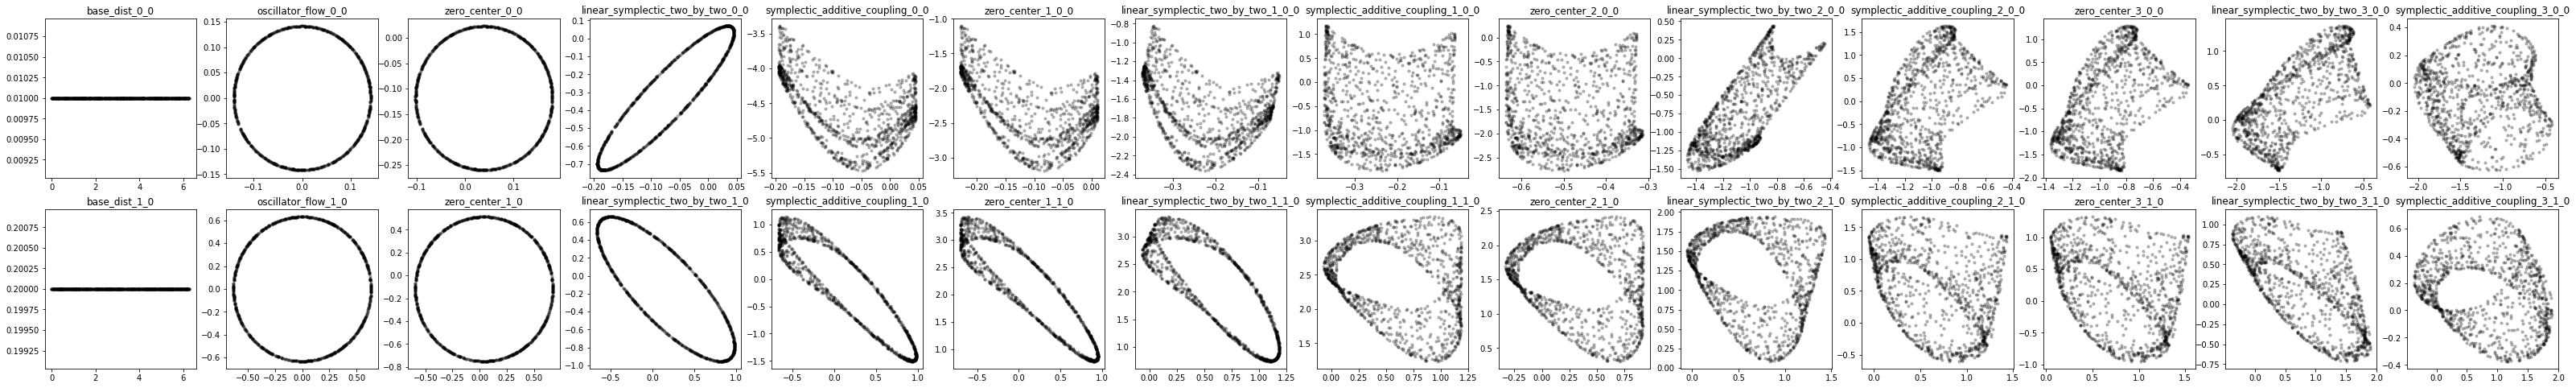

In [34]:
visualize_chain_bijector(T, z, sess=sess)

## Look at the Learned Representation

Try directly integrating the eom of the transformed Hamiltonian

In [35]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(lambda z : settings['hamiltonian'](T(z)),
                             initial_t=0., 
                             final_t=10., 
                             num_steps=1000)
# 1 random initial condition (scale it back so that the motion is in the sampled region)
z0 = sess.run( tf.expand_dims(z[0,:,:,:],0) )
print(z0)

[[[[4.178977 0.01    ]]

  [[4.791315 0.2     ]]]]


In [36]:
traj = sess.run( integrator(z0, return_full_state=True) )
# traj has shape (time,batch,d,n,2) Here batch trivial, squeeze it out, so that time becomes batch
traj = np.squeeze(traj, 1)
phi_traj, I_traj = extract_q_p( traj )

Visualize: the transformed trajectories

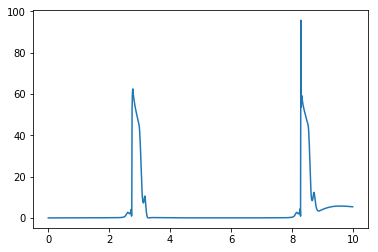

In [37]:
ts = np.arange(0.,10.,.01)

plt.plot(ts, I_traj[:,0,0,0])

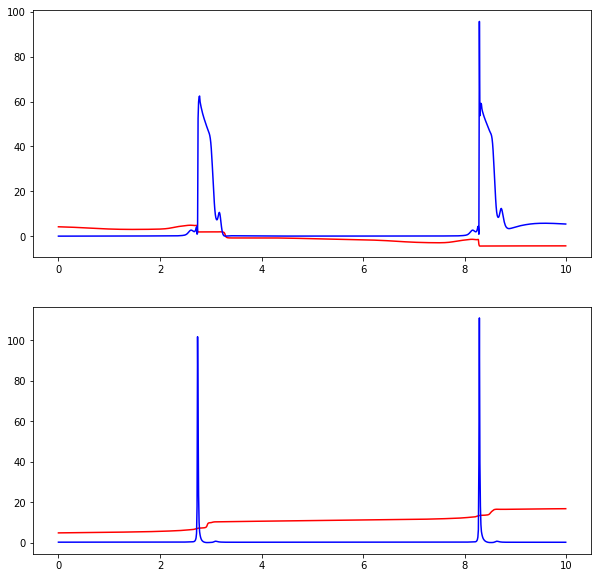

In [38]:
plt.figure(figsize=(10,10))

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        #plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0])
        plt.plot(ts[:], phi_traj[:,d,n,0],'r')
        plt.plot(ts[:], I_traj[:,d,n,0],'b')
        #plt.gca().set_aspect('equal', adjustable='box')

Almost there...

Trajectories of original Hamiltonian

In [39]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(settings['hamiltonian'],
                             initial_t=0., 
                             final_t=10., 
                             num_steps=1000)
# Map to original phase space the initial point
x0 = sess.run( T(tf.expand_dims(z[1,:,:,:],0)) )
print(x0)

[[[[-1.7307416  -0.28906178]]

  [[-0.23329127  0.28920662]]]]


In [40]:
print("q0: ", x0[:,:,:,0])
print("p0: ", x0[:,:,:,1])
print("E: ", sess.run( settings['hamiltonian'](x0) ))

q0:  [[[-1.7307416 ]
  [-0.23329127]]]
p0:  [[[-0.28906178]
  [ 0.28920662]]]
E:  -0.48900896


In [41]:
traj = sess.run( integrator(x0, return_full_state=True) )
# traj has shape (time,batch,d,n,2) Here batch trivial, squeeze it out, so that time becomes batch
traj = np.squeeze(traj, 1)
qtraj, ptraj = extract_q_p( traj )

visualize the trajectories

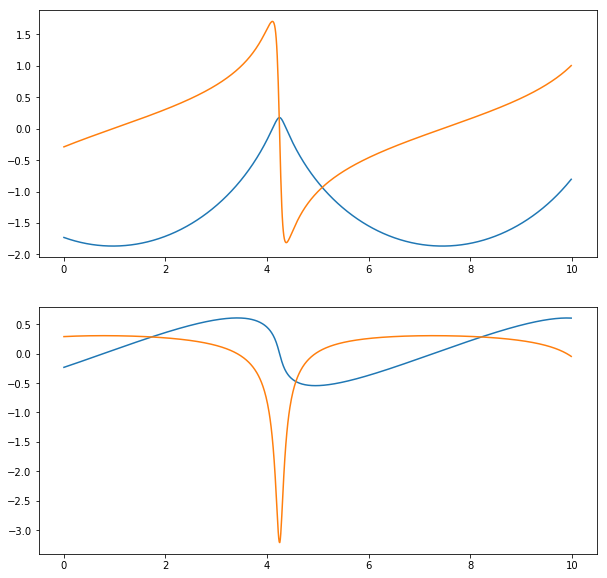

In [42]:
ts = np.arange(0.,10.,.01)

plt.figure(figsize=(10,10))

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        #plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0])
        plt.plot(ts, qtraj[:,d,n,0])
        plt.plot(ts, ptraj[:,d,n,0])

map back to action angle

In [43]:
ind_to_stop = 1
trans_traj = sess.run(T.inverse(tf.constant(traj), stop_at=ind_to_stop)) 
phi_trans_traj,I_trans_traj = extract_q_p(trans_traj)
if ind_to_stop == 0:
    osc_traj = T.bijectors[0](tf.constant(trans_traj))
else:
    osc_traj = tf.constant( trans_traj )
q_osc_traj,p_osc_traj = sess.run(extract_q_p(osc_traj))

In [44]:
dd = 0; nn = 0

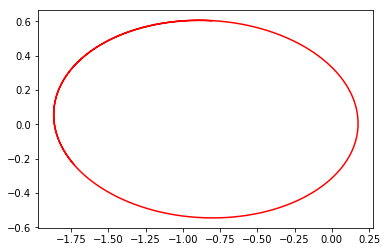

In [45]:
plt.plot(qtraj[:,0,nn,0], qtraj[:,1,nn,0],'r')

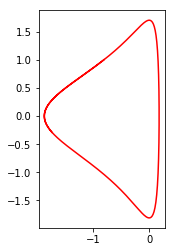

In [46]:
plt.plot(qtraj[:,dd,nn,0], ptraj[:,dd,nn,0],'r')
plt.gca().set_aspect('equal', adjustable='box')

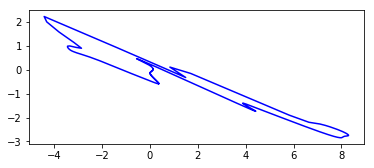

In [48]:
plt.plot(q_osc_traj[:,dd,nn,0], p_osc_traj[:,dd,nn,0],'b')
plt.gca().set_aspect('equal', adjustable='box')

## Conclusions

For the radii minimization loss, the model learns to set $K$ to zero within the region of sampling. This is in general not possible with a symplectic transformation - think about the case of oscillators and trying to set the Hamiltonian in the action-angle variables to zero. In fact it is possible with a time dependent canonical transformation like in Hamilton-Jacobi eq, where Hamilton principal function is its generating function (see Goldstein) but we will not consider it here.

Instead the transformation to $K=F_1$ makes sense and occurs when one solves time-independent Hamiltonian from the reduced Hamilton-Jacobi equation, and Hamilton characteristic function is its generating function (see Goldstein)

TODO: update below

Transformed trajectories

In [95]:
trans_traj = sess.run(T.inverse(traj))
qtraj, ptraj = extract_q_p(trans_traj)

Visualize: the transformed trajectories should be circles so that their radius is a constant of the motion

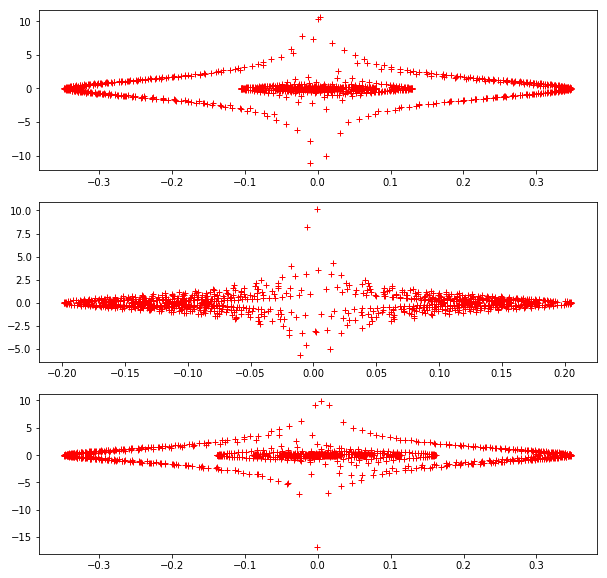

In [96]:
plt.figure(figsize=(10,10))

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        plt.plot(xtraj[:,d,n,0], ytraj[:,d,n,0],'r+')
        #plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0])
        #plt.xlim(-10, 10)
        #plt.ylim(-10, 10)
        #plt.plot(ts, xtraj[:,d,n,0])
        #plt.plot(ts, ytraj[:,d,n,0])
        
#        plt.gca().set_aspect('equal', adjustable='box')